# **Multiple Models ML Threshold Cross Validation**

# Preparing the MVTec Anomaly Detection Dataset for Model Training

This script is part of a pipeline for training anomaly detection models using the MVTec Anomaly Detection Dataset. The primary goal is to efficiently load, preprocess, and store extracted features while optimizing for memory efficiency. This dataset contains various categories of industrial objects, with images labeled as normal or anomalous.

## *1. Dataset Loading and Preprocessing*

### **1.1. Importing Required Libraries**

- os, shutil, pathlib → File and directory operations.
- numpy, pandas → Efficient data handling and manipulation.
- pickle → Saves and loads precomputed datasets to optimize computational efficiency.
  
- matplotlib, seaborn → Visualization tools for exploratory data analysis.
- PIL → Image processing.
- tqdm → Progress bar for iterating through data.
- torch, torchvision → Deep learning frameworks for image-based anomaly detection.
- sklearn.base → Custom transformer utilities for data preprocessing.

In [21]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pickle

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights
from sklearn.base import BaseEstimator, TransformerMixin

### **1.2. Defining the Dataset Directory**

- Constructs a normalized path (relative path) to the dataset folder.
- Defines the path to the feature metadata CSV file, which stores extracted feature representations of images.


In [22]:
# Load the dataset in chunks to avoid MemoryError
dataset_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), "..\..\..\Dataset")
dataset_dir = os.path.normpath(dataset_dir)
file_path = os.path.join(dataset_dir, 'mvtec_meta_features_dataset.csv')



### **1.3. Checkpointing: Efficiently Storing Extracted Features**

Using Checkpints:

- Avoids redundant computations: Loading extracted features from a .pkl file saves time and memory.
- Ensures consistency: The same dataset state is loaded every time unless explicitly reprocessed.

### **1.4. Loading the Feature Dataset in Chunks**
The feature dataset can be very large (thousands of images with high-dimensional features), so loading in chunks prevents crashes in memory-limited environments.

- Checks if a checkpoint exists:
  - If it does, it loads the previously computed feature dataset.
- If the checkpoint doesn’t exist:
  - The CSV file is read in chunks (size 1000) to prevent MemoryErrors.
  - The chunks are concatenated into a single DataFrame.
  - The resulting features_df is stored as a checkpoint file (.pkl) for future use.

In [1]:
# Define the checkpoint path
checkpoint_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'Checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'features_df_checkpoint.pkl')

# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
	# Load the DataFrame from the checkpoint file
	with open(checkpoint_path, 'rb') as f:
		features_df = pickle.load(f)
else:
	# Load the dataset in chunks to avoid MemoryError
	chunk_size = 1000  # Adjust the chunk size based on your memory capacity
	chunks = []
	for chunk in pd.read_csv(file_path, chunksize=chunk_size):
		chunks.append(chunk)
	features_df = pd.concat(chunks, ignore_index=True)

	# Save the DataFrame to a checkpoint file
	with open(checkpoint_path, 'wb') as f:
		pickle.dump(features_df, f)

# Display the first few rows of the DataFrame
features_df.head()

NameError: name 'os' is not defined

### **1.5. Extracting Unique Image Sizes by Category**
Organizing image paths into structured dictionaries allows for efficient data retrieval and model training.


- Groups the dataset by category.
- Extracts unique width-height pairs to understand the resolution distribution across different object types.
- Removes duplicates to get a clean list of unique sizes.

In [24]:
# Group by category and extract unique sizes
sizes_by_category = features_df.groupby('category')[['category', 'width', 'height']].apply(lambda x: x.drop_duplicates()).reset_index(drop=True)
sizes_by_category

,category,width,height
0,bottle,900,900
1,cable,1024,1024
2,capsule,1000,1000
3,carpet,1024,1024
4,grid,1024,1024
5,hazelnut,1024,1024
6,leather,1024,1024
7,metal_nut,700,700
8,pill,800,800
9,screw,1024,1024


### **1.6. List of the Categories**
To facilitate dataset loading, image file paths are gathered from different subdirectories:

- Train Images (train/): Normal samples used for training.
- Test Images (test/): Contains both normal and anomalous samples.
- Ground Truth Annotations (ground_truth/): Pixel-wise labels indicating the locations of anomalies.

Using the os.walk() function, the script recursively collects:

- All image file paths (.png, .jpg, etc.).
- Ground truth mask paths (for pixel-wise anomaly detection).

In [25]:
# create a list of the categories
categories = np.sort(features_df['category'].unique())

In [26]:
# Function to get all image and ground_truth paths for all categories
def load_image_paths_from_category(category):
    train_path = os.path.join(dataset_dir, category, 'train')
    test_path = os.path.join(dataset_dir, category, 'test')
    gt_path = os.path.join(dataset_dir, category, 'ground_truth')
    
    def get_image_paths(root_path):
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        image_paths = []
        for dirpath, _, filenames in os.walk(root_path):
            for filename in filenames:
                if filename.lower().endswith(image_extensions):
                    image_paths.append(os.path.join(dirpath, filename))
        return image_paths
    
    def get_ground_truth_paths(root_path):
        ground_truth_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        ground_truth_paths = []
        for dirpath, _, filenames in os.walk(root_path):
            for filename in filenames:
                if filename.lower().endswith(ground_truth_extensions):
                    ground_truth_paths.append(os.path.join(dirpath, filename))
        return ground_truth_paths
    
    # Get image and ground_truth paths
    train_image_paths = get_image_paths(train_path)
    test_image_paths = get_image_paths(test_path)
    gt_image_paths = get_ground_truth_paths(gt_path)
   
    return train_image_paths, test_image_paths, gt_image_paths

# Initialize dictionaries to store images
train_image_paths_dict = {}
test_image_paths_dict = {}
gt_image_paths_dict = {}

for category in categories:
    train_image_paths, test_image_paths, gt_image_paths = load_image_paths_from_category(category)
    train_image_paths_dict[category] = train_image_paths
    test_image_paths_dict[category] = test_image_paths
    gt_image_paths_dict[category] = gt_image_paths


### **1.7. Data Preprocessing and Cleaning**
Removing redundant metadata reduces computational overhead and ensures only essential features contribute to the anomaly detection task.


Before model training, the dataset undergoes:

- Feature Reduction: Unnecessary columns (width, height, aspect_ratio, bounding box coordinates, etc.) are removed to retain only relevant features.


- Dataset Restructuring: Data is categorized into:
  - Training Set: Used for model learning.
  - Test Set: Used for model evaluation.
  - Validation Set: Further split into cross-validation subsets.

- Feature Reduction: Removing unnecessary metadata improves processing efficiency.
- Focus on Relevant Features: Excludes non-essential attributes like bounding box details.

In [27]:
# Drop 'aspect_ratio', 'width', and 'height' columns if they exist
columns_to_drop = ['aspect_ratio', 'width', 'height', 'anomaly_type', 'subclass','object_count','bounding_box_area','bounding_box_aspect_ratio', 'bounding_box_x', 'bounding_box_y', 'bounding_box_width', 'bounding_box_height', 'perimeter']
features_df.drop(columns=[col for col in columns_to_drop if col in features_df.columns], inplace=True)

features_df


,category,set_type,anomaly_status,num_pixels_b,num_pixels_g,num_pixels_r,brightness_b,brightness_g,brightness_r,contrast_b,...,B_pixel_50173,R_pixel_50174,G_pixel_50174,B_pixel_50174,R_pixel_50175,G_pixel_50175,B_pixel_50175,R_pixel_50176,G_pixel_50176,B_pixel_50176
0,bottle,train,normal,6999311,6773371,6821573,139.495197,134.992247,135.952906,88.838658,...,255,255,255,255,255,255,255,255,255,255
1,bottle,train,normal,7067411,6860049,6919208,140.852419,136.719727,137.898756,89.026791,...,255,255,255,255,255,255,255,255,255,255
2,bottle,train,normal,6960857,6767973,6819394,138.728815,134.884666,135.909479,88.881780,...,255,255,255,255,255,255,255,255,255,255
3,bottle,train,normal,6941894,6749162,6805319,138.350885,134.509766,135.628966,89.623201,...,255,255,255,255,255,255,255,255,255,255
4,bottle,train,normal,7080991,6879424,6930908,141.123067,137.105867,138.131936,89.361566,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6078,zipper,validation,normal,5071897,5071897,5071897,101.082131,101.082131,101.082131,80.906218,...,255,255,255,255,255,255,255,255,255,255
6079,zipper,validation,normal,5195225,5195225,5195225,103.540039,103.540039,103.540039,81.662178,...,255,255,255,255,255,255,255,255,255,255
6080,zipper,validation,normal,5207096,5207096,5207096,103.776626,103.776626,103.776626,80.990008,...,255,255,255,255,255,255,255,255,255,255
6081,zipper,validation,normal,5110443,5110443,5110443,101.850347,101.850347,101.850347,82.455222,...,255,255,255,255,255,255,255,255,255,255


## *2. Splitting the Dataset*
Splitting the dataset into multiple evaluation subsets allows models to generalize better and avoids overfitting to a single test set.


To create a robust evaluation pipeline:

- The original test set is split into 40% test and 60% validation.
- The validation set is further divided into three equal cross-validation folds.

This stratified splitting ensures:

- Balanced distribution of normal and anomalous samples across test and validation sets.
- Reliable performance evaluation via cross-validation.

#### Explanation:

- Dataset Splitting: 40% test, 60% validation ensures robust evaluation.

- Stratified Sampling: Maintains a balanced anomaly distribution across splits.

- Removing Unnecessary Labels: Drops categorical labels (set_type, anomaly_status) after splitting.



In [1]:
from sklearn.model_selection import train_test_split

# Create dictionaries to store train, test, and validation dataframes and y_true labels for each category
train_dfs = {}
test_dfs = {}
validation_dfs = {}

y_true_test_dict = {}
y_true_validation_dict = {}

# Iterate over each category
for category in categories:
    # Filter the complete_df for the current category
    category_df = features_df[features_df['category'] == category]
    
    # Split into train and test dataframes based on 'set_type' column
    train_df = category_df[category_df['set_type'] == 'train'].copy()
    test_df = category_df[category_df['set_type'] == 'test'].copy()

    # Split the test dataframe into test and validation dataframes
    test_df, validation_df, y_true_test, y_true_validation = train_test_split(
        test_df, test_df['anomaly_status'].apply(lambda x: 0 if x == 'normal' else 1).reset_index(drop=True), 
        test_size=0.60, random_state=42, stratify=test_df['anomaly_status'].apply(lambda x: 0 if x == 'normal' else 1))
    
    # Store the true labels for the test and validation data
    y_true_test_dict[category] = y_true_test.reset_index(drop=True)
    y_true_validation_dict[category] = y_true_validation.reset_index(drop=True)
    
    # Drop the 'set_type' and 'anomaly_status' columns
    train_df.drop(columns=['set_type', 'anomaly_status'], inplace=True)
    test_df.drop(columns=['set_type', 'anomaly_status'], inplace=True)
    validation_df.drop(columns=['set_type', 'anomaly_status'], inplace=True)
    
    # Reinitialize the indices
    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    validation_df.reset_index(drop=True, inplace=True)
   
    # Store the dataframes in the dictionaries
    train_dfs[category] = train_df
    test_dfs[category] = test_df
    validation_dfs[category] = validation_df


NameError: name 'categories' is not defined

- Cross-Validation Splitting: Divides validation data into three subsets.
- Ensures Robust Evaluation: Allows multiple training/testing scenarios to improve generalization.

In [77]:
from sklearn.model_selection import train_test_split

# Initialize dictionaries to store cross-validation dataframes and y_true labels for each category
cv_dfs_1 = {}
cv_dfs_2 = {}
cv_dfs_3 = {}

y_true_cv_dict_1 = {}
y_true_cv_dict_2 = {}
y_true_cv_dict_3 = {}

# Iterate over each category
for category in categories:
    # Get the validation dataframe for the current category
    validation_df = validation_dfs[category]
    y_true_validation = y_true_validation_dict[category]
    
    # Split the validation dataframe into three cross-validation sets
    cv_df_1, temp_df, y_true_cv_1, y_true_temp = train_test_split(validation_df, y_true_validation, test_size=2/3, random_state=42, stratify=y_true_validation)
    cv_df_2, cv_df_3, y_true_cv_2, y_true_cv_3 = train_test_split(temp_df, y_true_temp, test_size=1/2, random_state=42, stratify=y_true_temp)
    
    # Reinitialize the indices
    cv_df_1.reset_index(drop=True, inplace=True)
    cv_df_2.reset_index(drop=True, inplace=True)
    cv_df_3.reset_index(drop=True, inplace=True)
    
    # Store the dataframes and true labels in the dictionaries
    cv_dfs_1[category] = cv_df_1
    cv_dfs_2[category] = cv_df_2
    cv_dfs_3[category] = cv_df_3
    
    y_true_cv_dict_1[category] = y_true_cv_1
    y_true_cv_dict_2[category] = y_true_cv_2
    y_true_cv_dict_3[category] = y_true_cv_3

## *3. Standardization of the Data*
Standardization prevents certain features from dominating due to scale differences, ensuring balanced model training.

Since machine learning models perform better with standardized input, the script:

- Uses StandardScaler() to normalize numerical features.
- Separates category labels before applying scaling.
- Applies the same transformation to train, test, validation, and cross-validation sets.

This step ensures:

- Features are transformed to have zero mean and unit variance.
- Differences in feature scales (e.g., raw pixel values vs. aggregated statistics) do not bias the model.


In [78]:
from sklearn.preprocessing import StandardScaler

# Initialize dictionaries to store normalized train, test, validation, and cross-validation dataframes
normalized_train_dfs = {}
normalized_test_dfs = {}
normalized_validation_dfs = {}
normalized_cv_dfs_1 = {}
normalized_cv_dfs_2 = {}
normalized_cv_dfs_3 = {}

# Iterate over each category
for category in categories:
    # Get the original train, test, validation, and cross-validation dataframes for the current category
    train_df = train_dfs[category]
    test_df = test_dfs[category]
    validation_df = validation_dfs[category]
    cv_df_1 = cv_dfs_1[category]
    cv_df_2 = cv_dfs_2[category]
    cv_df_3 = cv_dfs_3[category]
    
    # Separate features and target
    X_train = train_df.drop(columns=['category']).values
    X_test = test_df.drop(columns=['category']).values
    X_validation = validation_df.drop(columns=['category']).values
    X_cv_1 = cv_df_1.drop(columns=['category']).values
    X_cv_2 = cv_df_2.drop(columns=['category']).values
    X_cv_3 = cv_df_3.drop(columns=['category']).values
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_validation_scaled = scaler.transform(X_validation)
    X_cv_1_scaled = scaler.transform(X_cv_1)
    X_cv_2_scaled = scaler.transform(X_cv_2)
    X_cv_3_scaled = scaler.transform(X_cv_3)
    
    # Create new DataFrames with the normalized features
    train_df_normalized = pd.DataFrame(data=X_train_scaled, columns=train_df.drop(columns=['category']).columns)
    train_df_normalized['category'] = train_df['category'].values
    
    test_df_normalized = pd.DataFrame(data=X_test_scaled, columns=test_df.drop(columns=['category']).columns)
    test_df_normalized['category'] = test_df['category'].values
    
    validation_df_normalized = pd.DataFrame(data=X_validation_scaled, columns=validation_df.drop(columns=['category']).columns)
    validation_df_normalized['category'] = validation_df['category'].values
    
    cv_df_1_normalized = pd.DataFrame(data=X_cv_1_scaled, columns=cv_df_1.drop(columns=['category']).columns)
    cv_df_1_normalized['category'] = cv_df_1['category'].values
    
    cv_df_2_normalized = pd.DataFrame(data=X_cv_2_scaled, columns=cv_df_2.drop(columns=['category']).columns)
    cv_df_2_normalized['category'] = cv_df_2['category'].values
    
    cv_df_3_normalized = pd.DataFrame(data=X_cv_3_scaled, columns=cv_df_3.drop(columns=['category']).columns)
    cv_df_3_normalized['category'] = cv_df_3['category'].values
    
    # Store the normalized dataframes in the dictionaries
    normalized_train_dfs[category] = train_df_normalized
    normalized_test_dfs[category] = test_df_normalized
    normalized_validation_dfs[category] = validation_df_normalized
    normalized_cv_dfs_1[category] = cv_df_1_normalized
    normalized_cv_dfs_2[category] = cv_df_2_normalized
    normalized_cv_dfs_3[category] = cv_df_3_normalized


- Feature Scaling: Standardizes numerical values to have zero mean and unit variance.
- Consistent Transformation: Same scaling is applied to all dataset splits.

## *4. Dimentionality Reduction with PCA*

In this step, we apply PCA to reduce the number of features in our dataset while preserving 95% of the variance. This is particularly useful for anomaly detection because it helps eliminate noise and redundant information, allowing models to focus on the most important patterns.


### Loading or Computing PCA Features

- First, we define a checkpoint path to save and reload PCA-transformed features efficiently.

- We initialize dictionaries to store PCA-transformed datasets separately for training, testing, validation, and cross-validation sets.


### Checking for Precomputed PCA Features

- If a checkpoint file exists, we directly load the PCA-transformed data to save computation time.

- This prevents unnecessary recalculations, which is especially beneficial for large datasets.


### Applying PCA to Each Data Split

- If PCA features are not precomputed, we extract the feature columns (excluding the category label).

- We apply PCA with n_components=0.95, meaning we keep only the components that explain 95% of the variance.

- The PCA transformation is first fitted on the training set and then applied to test, validation, and cross-validation sets.


### Converting PCA Components to DataFrames

- The PCA-transformed principal components (PCs) are stored in new DataFrames.

- We add back the category label to maintain reference to the original dataset.

### Saving PCA-Transformed Data for Future Use

The PCA-transformed DataFrames are stored in a pickle file for efficient retrieval in future runs.

In [130]:
from sklearn.decomposition import PCA

# Define the checkpoint path
pca_checkpoint_path = os.path.join(checkpoint_dir, 'pca_features_df_cv_checkpoint.pkl')

# Initialize dictionaries to store PCA-transformed train, test, validation, and cross-validation dataframes
pca_train_dfs = {}
pca_test_dfs = {}
pca_validation_dfs = {}
pca_cv_dfs_1 = {}
pca_cv_dfs_2 = {}
pca_cv_dfs_3 = {}

# Check if the checkpoint file exists
if os.path.exists(pca_checkpoint_path):
    # Load the PCA-transformed DataFrames from the checkpoint file
    with open(pca_checkpoint_path, 'rb') as f:
        pca_data = pickle.load(f)
        pca_train_dfs = pca_data['train']
        pca_test_dfs = pca_data['test']
        pca_validation_dfs = pca_data['validation']
        pca_cv_dfs_1 = pca_data['cv_1']
        pca_cv_dfs_2 = pca_data['cv_2']
        pca_cv_dfs_3 = pca_data['cv_3']
else:
    # Iterate over each category
    for category in categories:
        # Get the original train, test, validation, and cross-validation dataframes for the current category
        train_df = normalized_train_dfs[category]
        test_df = normalized_test_dfs[category]
        validation_df = normalized_validation_dfs[category]
        cv_df_1 = normalized_cv_dfs_1[category]
        cv_df_2 = normalized_cv_dfs_2[category]
        cv_df_3 = normalized_cv_dfs_3[category]

        # Separate features and target
        X_train = train_df.drop(columns=['category']).values
        X_test = test_df.drop(columns=['category']).values
        X_validation = validation_df.drop(columns=['category']).values
        X_cv_1 = cv_df_1.drop(columns=['category']).values
        X_cv_2 = cv_df_2.drop(columns=['category']).values
        X_cv_3 = cv_df_3.drop(columns=['category']).values

        # Apply PCA
        pca = PCA(n_components=0.95)  # Retain features explaining 95% of the variance
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        X_validation_pca = pca.transform(X_validation)
        X_cv_1_pca = pca.transform(X_cv_1)
        X_cv_2_pca = pca.transform(X_cv_2)
        X_cv_3_pca = pca.transform(X_cv_3)

        # Create new DataFrames with the PCA components
        train_df_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
        train_df_pca['category'] = train_df['category'].values

        test_df_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
        test_df_pca['category'] = test_df['category'].values

        validation_df_pca = pd.DataFrame(data=X_validation_pca, columns=[f'PC{i+1}' for i in range(X_validation_pca.shape[1])])
        validation_df_pca['category'] = validation_df['category'].values

        cv_df_1_pca = pd.DataFrame(data=X_cv_1_pca, columns=[f'PC{i+1}' for i in range(X_cv_1_pca.shape[1])])
        cv_df_1_pca['category'] = cv_df_1['category'].values

        cv_df_2_pca = pd.DataFrame(data=X_cv_2_pca, columns=[f'PC{i+1}' for i in range(X_cv_2_pca.shape[1])])
        cv_df_2_pca['category'] = cv_df_2['category'].values

        cv_df_3_pca = pd.DataFrame(data=X_cv_3_pca, columns=[f'PC{i+1}' for i in range(X_cv_3_pca.shape[1])])
        cv_df_3_pca['category'] = cv_df_3['category'].values

        # Store the PCA-transformed dataframes in the dictionaries
        pca_train_dfs[category] = train_df_pca
        pca_test_dfs[category] = test_df_pca
        pca_validation_dfs[category] = validation_df_pca
        pca_cv_dfs_1[category] = cv_df_1_pca
        pca_cv_dfs_2[category] = cv_df_2_pca
        pca_cv_dfs_3[category] = cv_df_3_pca

    # Save the PCA-transformed DataFrames to a checkpoint file
    with open(pca_checkpoint_path, 'wb') as f:
        pickle.dump({
            'train': pca_train_dfs,
            'test': pca_test_dfs,
            'validation': pca_validation_dfs,
            'cv_1': pca_cv_dfs_1,
            'cv_2': pca_cv_dfs_2,
            'cv_3': pca_cv_dfs_3
        }, f)


### Examining PCA Feature Counts

- This table summarizes the number of PCA components retained per dataset.
- The reduction in features indicates effective dimensionality reduction while still capturing important variance.



In [131]:
# Print the number of PCA features for each category in train, test, validation, and cross-validation sets
table_data = []

for category in categories:
    train_df = pca_train_dfs[category]
    test_df = pca_test_dfs[category]
    validation_df = pca_validation_dfs[category]
    cv_df_1 = pca_cv_dfs_1[category]
    cv_df_2 = pca_cv_dfs_2[category]
    cv_df_3 = pca_cv_dfs_3[category]
    table_data.append([
        category, 
        train_df.shape[1] - 1,  # Subtract 1 to exclude the 'category' column
        test_df.shape[1] - 1,   # Subtract 1 to exclude the 'category' column
        validation_df.shape[1] - 1,  # Subtract 1 to exclude the 'category' column
        cv_df_1.shape[1] - 1,  # Subtract 1 to exclude the 'category' column
        cv_df_2.shape[1] - 1,  # Subtract 1 to exclude the 'category' column
        cv_df_3.shape[1] - 1   # Subtract 1 to exclude the 'category' column
    ])

# Create a DataFrame to display the table
pca_features_table = pd.DataFrame(table_data, columns=[
    'Category', 
    'Train PCA Features', 
    'Test PCA Features', 
    'Validation PCA Features', 
    'CV1 PCA Features', 
    'CV2 PCA Features', 
    'CV3 PCA Features'
])
pca_features_table


,Category,Train PCA Features,Test PCA Features,Validation PCA Features,CV1 PCA Features,CV2 PCA Features,CV3 PCA Features
0,bottle,170,170,170,170,170,170
1,cable,181,181,181,181,181,181
2,capsule,161,161,161,161,161,161
3,carpet,249,249,249,249,249,249
4,grid,193,193,193,193,193,193
5,hazelnut,301,301,301,301,301,301
6,leather,220,220,220,220,220,220
7,metal_nut,192,192,192,192,192,192
8,pill,205,205,205,205,205,205
9,screw,71,71,71,71,71,71


### Checking Dataset Lengths

Checking the lenght of the list of all the train test and validation dataset ensures that the dataset sizes remain consistent before and after PCA transformation.

In [132]:
# Create a list to store the data
length_data = []

# Iterate over each category
for category in categories:
    train_length = len(train_dfs[category])
    y_true_test_length = len(y_true_test_dict[category])
    pca_test_length = len(pca_test_dfs[category])
    y_true_validation_length = len(y_true_validation_dict[category])
    pca_validation_length = len(validation_dfs[category])
    y_true_cv_1_length = len(y_true_cv_dict_1[category])
    pca_cv_1_length = len(cv_dfs_1[category])
    y_true_cv_2_length = len(y_true_cv_dict_2[category])
    pca_cv_2_length = len(cv_dfs_2[category])
    y_true_cv_3_length = len(y_true_cv_dict_3[category])
    pca_cv_3_length = len(cv_dfs_3[category])
    
    length_data.append([category, train_length, y_true_test_length, pca_test_length, y_true_validation_length, pca_validation_length, y_true_cv_1_length, pca_cv_1_length, y_true_cv_2_length, pca_cv_2_length, y_true_cv_3_length, pca_cv_3_length])

# Create a DataFrame to display the table
length_table = pd.DataFrame(length_data, columns=['Category','train_df Length', 'y_true_test Length', 'pca_test_df Length', 'y_true_validation Length', 'pca_validation_df Length', 'y_true_cv_1 Length', 'pca_cv_1_df Length', 'y_true_cv_2 Length', 'pca_cv_2_df Length', 'y_true_cv_3 Length', 'pca_cv_3_df Length'])
length_table

,Category,train_df Length,y_true_test Length,pca_test_df Length,y_true_validation Length,pca_validation_df Length,y_true_cv_1 Length,pca_cv_1_df Length,y_true_cv_2 Length,pca_cv_2_df Length,y_true_cv_3 Length,pca_cv_3_df Length
0,bottle,209,33,33,50,50,16,16,17,17,17,17
1,cable,224,60,60,90,90,30,30,30,30,30,30
2,capsule,219,52,52,80,80,26,26,27,27,27,27
3,carpet,280,46,46,71,71,23,23,24,24,24,24
4,grid,264,31,31,47,47,15,15,16,16,16,16
5,hazelnut,391,44,44,66,66,22,22,22,22,22,22
6,leather,245,49,49,75,75,25,25,25,25,25,25
7,metal_nut,220,46,46,69,69,23,23,23,23,23,23
8,pill,267,66,66,101,101,33,33,34,34,34,34
9,screw,320,64,64,96,96,32,32,32,32,32,32


### Checking Distribution of Normal vs Anomalous Samples

- Here, we verify the balance between normal and anomalous samples across test, validation, and cross-validation sets.

- This information is crucial for evaluating model performance, ensuring that it has a fair number of anomalies to learn from.


In [133]:
# Initialize a dictionary to store the counts
data_counts = {}

# Iterate over each category
for category in categories:
    data_counts[category] = {
        'test_normal': (y_true_test_dict[category] == 0).sum(),
        'test_anomalous': (y_true_test_dict[category] == 1).sum(),
        'validation_normal': (y_true_validation_dict[category] == 0).sum(),
        'validation_anomalous': (y_true_validation_dict[category] == 1).sum(),
        'cv_1_normal': (y_true_cv_dict_1[category] == 0).sum(),
        'cv_1_anomalous': (y_true_cv_dict_1[category] == 1).sum(),
        'cv_2_normal': (y_true_cv_dict_2[category] == 0).sum(),
        'cv_2_anomalous': (y_true_cv_dict_2[category] == 1).sum(),
        'cv_3_normal': (y_true_cv_dict_3[category] == 0).sum(),
        'cv_3_anomalous': (y_true_cv_dict_3[category] == 1).sum()
    }

# Convert the dictionary to a DataFrame for better visualization
data_counts_df = pd.DataFrame(data_counts).T
data_counts_df

,test_normal,test_anomalous,validation_normal,validation_anomalous,cv_1_normal,cv_1_anomalous,cv_2_normal,cv_2_anomalous,cv_3_normal,cv_3_anomalous
bottle,8,25,12,38,4,12,4,13,4,13
cable,23,37,35,55,12,18,11,19,12,18
capsule,9,43,14,66,5,21,4,23,5,22
carpet,11,35,17,54,6,17,5,19,6,18
grid,8,23,13,34,4,11,4,12,5,11
hazelnut,16,28,24,42,8,14,8,14,8,14
leather,13,36,19,56,6,19,6,19,7,18
metal_nut,9,37,13,56,4,19,4,19,5,18
pill,10,56,16,85,5,28,5,29,6,28
screw,16,48,25,71,8,24,8,24,9,23


### Summary of PCA Implementation


- PCA was successfully applied to reduce high-dimensional feature spaces into a lower-dimensional representation while retaining 95% of the variance.
- The transformed datasets were stored for future use, saving computational time.
- The number of retained PCA components varies across categories, but all datasets remain consistent in size.

## *5. Multiple Models*

### Training Multiple Anomaly Detection Models

The primary goal is to perform a hyperparameter grid search and evaluate different models based on the harmonic mean of AUROC and PRO-AUC (denoted as Ph). We will explore various models, including One-Class SVM (OC-SVM), Isolation Forest, Local Outlier Factor (LOF), and Elliptic Envelope, to determine their effectiveness in anomaly detection across different datasets.

### **5.1. Model Selection and Hyperparameter Tuning**

#### Models Considered

We use four different anomaly detection algorithms, each with unique strengths:

- One-Class SVM (OC-SVM): A kernel-based method that learns a decision function for anomaly detection.

- Isolation Forest: A tree-based approach that isolates anomalies through recursive partitioning.

- Local Outlier Factor (LOF): A density-based algorithm that identifies anomalies by comparing local densities.

- Elliptic Envelope: A statistical model that assumes Gaussian-distributed data and finds outliers based on Mahalanobis distance.

* Each model undergoes a grid search to optimize its hyperparameters and enhance performance.

Run a grid search over the hyperparameters and over the threshold using metric harmonic_mean_auroc_proauc (Ph)

### **5.2. Hyperparameter Grid Definitions**

#### Explanation of Hyperparameters

- OC-SVM:

  - nu: The proportion of outliers expected in the data.
  - kernel: Choice of kernel function for SVM (Radial Basis Function, Linear, Polynomial).
  - gamma: Kernel coefficient for rbf, poly, and sigmoid kernels.
  - degree: Degree of polynomial kernel.

- Isolation Forest:

  - n_estimators: Number of base estimators (trees) in the ensemble.
  - contamination: Proportion of anomalies expected in the dataset.
  - max_samples: Number of samples to train each tree.
  - max_features: Number of features used in each tree split.

- LOF:

  - n_neighbors: Number of neighbors used to compute local density.
  - contamination: Expected fraction of anomalies.
  - leaf_size: Size of leaves in the k-d tree used for nearest neighbor searches.
  - algorithm: Algorithm for nearest neighbor search.
  - metric: Distance metric (Minkowski or Euclidean).

- Elliptic Envelope:

  - contamination: Expected fraction of outliers.
  - support_fraction: Proportion of observations used to compute robust covariance.
  - assume_centered: If True, the input data is assumed to be centered.

### **5.3. Checkpointing and Saving Model Results**

To ensure computational efficiency, we use checkpointing to save model results and resume training if needed. This ensures that previously computed results are loaded, preventing redundant computations.



### **5.4. Training and Evaluation Process**

For each dataset category, we:

- Load PCA-transformed training data.

- Iterate over each model and its corresponding hyperparameter grid.

- Train the model and compute anomaly scores.

- Evaluate using AUROC (Area Under the Receiver Operating Characteristic Curve).

- Save the results for each hyperparameter combination.


### **5.5. Model Evaluation Using AUROC**

To compare models, we compute the AUROC score, which measures the tradeoff between True Positive Rate (TPR) and False Positive Rate (FPR). We store these results and periodically save a checkpoint to prevent data loss.

In [134]:
import time
import os
import pickle
from sklearn.model_selection import ParameterGrid
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score


param_grids = {
    'oc_svm': {
        'nu': [0.001],
        'kernel': ['rbf', 'linear', 'poly'], 
        'gamma': ['scale', 'auto'],
        'degree': [2, 3]
    },
    'isolation_forest': {
        'n_estimators': [100, 200, 300, 400],
        'contamination': [0.01],
        'max_samples': ['auto',  1.0],
        'max_features': [0.9, 1.0]
    },
    'lof': {
        'n_neighbors': [10, 20, 30, 50],
        'contamination': [0.01],
        'leaf_size': [20, 30, 50, 100],
        'algorithm': ['auto'],
        'metric': ['minkowski', 'euclidean']
        
    }, 
    'eliptic envelope': {
        'contamination': [0.01],
        'support_fraction': [ 0.9, 1.0],
        'assume_centered': [True, False]
    }
}

# Define checkpoint path
model_results_checkpoint_path = os.path.join(checkpoint_dir, 'model_results_cv_checkpoint.pkl')

# Load existing results if checkpoint exists
if os.path.exists(model_results_checkpoint_path):
    try:
        with open(model_results_checkpoint_path, 'rb') as f:
            saved_model_results = pickle.load(f)
    except EOFError:
        print("Checkpoint file is empty or corrupted. Initializing empty results.")
        saved_model_results = {}
else:
    saved_model_results = {}

# Initialize results structure if needed
for category in categories:
    if category not in saved_model_results:
        saved_model_results[category] = {}
    for model_name in param_grids.keys():
        if model_name not in saved_model_results[category]:
            saved_model_results[category][model_name] = {}

for category in tqdm(categories, desc="Categories"):
    start_time = time.time()
    train_df_pca = pca_train_dfs[category]
    X_train_pca = train_df_pca.drop(columns=['category']).values
    
    for model_name, param_grid in param_grids.items():
        param_list = list(ParameterGrid(param_grid))
        
        # Skip if all parameters already computed
        if all(any(res['params'] == p for res in saved_model_results[category][model_name].get('results', []))
               for p in param_list):
            print(f"Skipping {model_name} for {category} since all parameters were already computed.")
            continue

        for params in tqdm(param_list, desc=f"{category} - {model_name}", leave=False):
            # Skip if this parameter combination already computed
            if any(res['params'] == params for res in saved_model_results[category][model_name].get('results', [])):
                continue
                
            print(f"Category: {category}, Model: {model_name}, Params: {params}")
            
            if model_name == 'oc_svm':
                model = OneClassSVM(**params)
            elif model_name == 'isolation_forest':
                model = IsolationForest(**params)
            elif model_name == 'lof':
                model = LocalOutlierFactor(**params, novelty=True)
            
            # Train model
            model.fit(X_train_pca)
            
            # Get validation scores for all three cross-validation datasets
            X_cv_pca_1 = pca_cv_dfs_1[category].drop(columns=['category']).values
            X_cv_pca_2 = pca_cv_dfs_2[category].drop(columns=['category']).values
            X_cv_pca_3 = pca_cv_dfs_3[category].drop(columns=['category']).values
            y_true_cv_1 = y_true_cv_dict_1[category]
            y_true_cv_2 = y_true_cv_dict_2[category]
            y_true_cv_3 = y_true_cv_dict_3[category]
            
            # Get decision scores (different methods for different models)
            if model_name == 'lof':
                decision_scores_1 = model.decision_function(X_cv_pca_1)
                decision_scores_2 = model.decision_function(X_cv_pca_2)
                decision_scores_3 = model.decision_function(X_cv_pca_3)
            else:
                decision_scores_1 = model.score_samples(X_cv_pca_1) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_1)
                decision_scores_2 = model.score_samples(X_cv_pca_2) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_2)
                decision_scores_3 = model.score_samples(X_cv_pca_3) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_3)
            
            auc_roc_1 = roc_auc_score(y_true_cv_1, decision_scores_1)
            auc_roc_2 = roc_auc_score(y_true_cv_2, decision_scores_2)
            auc_roc_3 = roc_auc_score(y_true_cv_3, decision_scores_3)
            avg_auc_roc = (auc_roc_1 + auc_roc_2 + auc_roc_3) / 3
            
            # Save results
            if 'results' not in saved_model_results[category][model_name]:
                saved_model_results[category][model_name]['results'] = []
            
            saved_model_results[category][model_name]['results'].append({
                'params': params,
                'auc_roc_1': auc_roc_1,
                'auc_roc_2': auc_roc_2,
                'auc_roc_3': auc_roc_3,
                'avg_auc_roc': avg_auc_roc,
                'model': model
            })
            
            # Save checkpoint
            with open(model_results_checkpoint_path, 'wb') as f:
                pickle.dump(saved_model_results, f)


Categories:  93%|█████████▎| 14/15 [17:11<01:57, 117.46s/it]

Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.001}


Category: zipper, Model: oc_svm, Params: {'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.001}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 'auto', 'n_estimators': 400}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 400}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 400}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Category: zipper, Model: isolation_forest, Params: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 400}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 50, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'minkowski', 'n_neighbors': 50}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 10}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 20}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 30}


Category: zipper, Model: lof, Params: {'algorithm': 'auto', 'contamination': 0.01, 'leaf_size': 100, 'metric': 'euclidean', 'n_neighbors': 50}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 0.9}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': True, 'contamination': 0.01, 'support_fraction': 1.0}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 0.9}


Category: zipper, Model: eliptic envelope, Params: {'assume_centered': False, 'contamination': 0.01, 'support_fraction': 1.0}


Categories: 100%|██████████| 15/15 [19:49<00:00, 79.27s/it] 


### **5.6. Creating a DataFrame of Model Results**

We have multiple anomaly detection models applied to different categories, and we want to collect their results into a structured format.

- We have different categories (e.g., "bottle," "cable," "capsule").
- For each category, there are different models (e.g., oc_svm, lof, isolation_forest, etc.).
- Each model has multiple hyperparameter configurations, and for each configuration, we have a corresponding AUC ROC score (which measures the model's performance).
- The goal is to flatten this data into a Pandas DataFrame where each row represents a model, its hyperparameters, and its AUC ROC score.

#### Procedure

- We start with an empty list all_results that will hold all the model results in a structured format.

- We loop through each category, meaning we process one product type (e.g., "bottle," "capsule") at a time.

- For the current category, we iterate over each model type (e.g., oc_svm, lof, etc.).

- model_results contains multiple runs of the same model with different hyperparameter settings.

- Each model has multiple evaluations with different hyperparameters, so we loop through each of them.

- The params dictionary contains hyperparameters (e.g., kernel type, contamination factor).

- We flatten this dictionary by renaming each key as 'param_' + key to avoid conflicts when creating a DataFrame..

In [135]:
# Initialize a list to store the results
all_results = []

# Iterate over each category
for category in categories:
    # Iterate over each model and its results
    for model_name, model_results in saved_model_results[category].items():
        for result in model_results['results']:
            # Flatten the parameters dictionary
            params = result['params']
            flattened_params = {f'param_{key}': value for key, value in params.items()}
            
            # Append the category, model name, parameters, and AUC ROC score to the results list
            all_results.append({
                'Category': category,
                'Model': model_name,
                'AUC_ROC': result['avg_auc_roc'],
                **flattened_params
            })

# Create a DataFrame from the results list
results_df_1 = pd.DataFrame(all_results)



- We store the category, model name, AUC ROC score, and all hyperparameters as a dictionary inside all_results. 

- We convert all_results into a Pandas DataFrame (results_df_1) and display it.

In [136]:
# Display the DataFrame
results_df_1

,Category,Model,AUC_ROC,param_degree,param_gamma,param_kernel,param_nu,param_contamination,param_max_features,param_max_samples,param_n_estimators,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_assume_centered,param_support_fraction
0,bottle,oc_svm,0.275107,2.0,scale,rbf,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bottle,oc_svm,0.580128,2.0,scale,linear,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bottle,oc_svm,0.603632,2.0,scale,poly,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bottle,oc_svm,0.500000,2.0,auto,rbf,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bottle,oc_svm,0.580128,2.0,auto,linear,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,zipper,lof,0.619709,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,auto,100.0,euclidean,50.0,NaN,NaN
956,zipper,eliptic envelope,0.619709,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.9
957,zipper,eliptic envelope,0.619709,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0
958,zipper,eliptic envelope,0.619709,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.9


- Models were evaluated multiple times with different parameter settings.
- AUC ROC values vary across runs, meaning that the model's performance depends on the hyperparameters.
- Some models may perform better on specific categories, while others might struggle.

### **5.7. Extracting the Best Model for Each Method**

- For each (Category, Model) combination, we want to find the best-performing model configuration (i.e., the one with the highest AUC ROC score).
- We then create a pivot table where each row corresponds to a Category, and each column represents the best AUC ROC score per model.

#### Explanations:

- Grouping by Category and Model: This ensures that we look at each model's performance within each category.
- idxmax(): Finds the index of the row with the highest AUC ROC score for that model-category pair.
- .loc[...]: Selects the best-performing rows from results_df_1.

- .pivot(): Reshapes the data to create a table where:
- Rows → Unique categories (e.g., "bottle," "capsule").
- Columns → Different models (e.g., oc_svm, lof, etc.).
- Values → The best AUC ROC score for each category-model pair.
- .round(3): Rounds AUC ROC scores to three decimal places.

- Renames the columns to include "AUC_ROC " as a prefix, making it clearer that the values are AUC ROC scores.
- Sorting the table by category for better readability.

In [137]:
# Group by Category and Model, find the best AUC ROC for each combination
best_models_df = results_df_1.loc[results_df_1.groupby(['Category', 'Model'])['AUC_ROC'].idxmax()]

# Create separate columns for each model's AUC ROC
auc_roc_pivot = best_models_df.pivot(index='Category', columns='Model', values='AUC_ROC').round(3)
auc_roc_pivot.columns = ['AUC_ROC ' + col for col in auc_roc_pivot.columns]

# Sort by Category
best_models_pivot = auc_roc_pivot.sort_index()

# Display the results
best_models_pivot


,AUC_ROC eliptic envelope,AUC_ROC isolation_forest,AUC_ROC lof,AUC_ROC oc_svm
Category,,,,
bottle,0.258,0.229,0.258,0.610
cable,0.408,0.508,0.566,0.521
capsule,0.460,0.534,0.460,0.586
carpet,0.481,0.579,0.481,0.571
grid,0.172,0.327,0.172,0.678
hazelnut,0.893,0.321,0.893,0.527
leather,0.461,0.481,0.461,0.646
metal_nut,0.508,0.540,0.508,0.546
pill,0.599,0.378,0.599,0.650




### **5.8. Bar Plot of AUC-ROC Scores for Each Model**

- Import necessary libraries: `numpy` for numerical operations and `matplotlib.pyplot` for visualization.
- Set the figure size to `(14, 8)` for better readability.
- Define the width of the bars using `bar_width = 0.2`.
- Set the positions of the bars on the x-axis using `np.arange()` based on the number of categories.
- Iterate over each model in `best_models_pivot.columns` to plot bars:
  - Offset the bars by `i * bar_width` to avoid overlap.
  - Use `plt.bar()` to create a bar for each model.
- Customize the plot with labels and title:
  - X-axis label: `'Category'`
  - Y-axis label: `'AUC_ROC Score'`
  - Title: `'AUC_ROC Score by Category for Each Model'`
- Adjust x-axis ticks:
  - Center the labels relative to grouped bars.
  - Rotate category labels for better readability.
- Add a legend to differentiate models.
- Use `plt.tight_layout()` to prevent layout overlap.
- Display the plot with `plt.show()`.


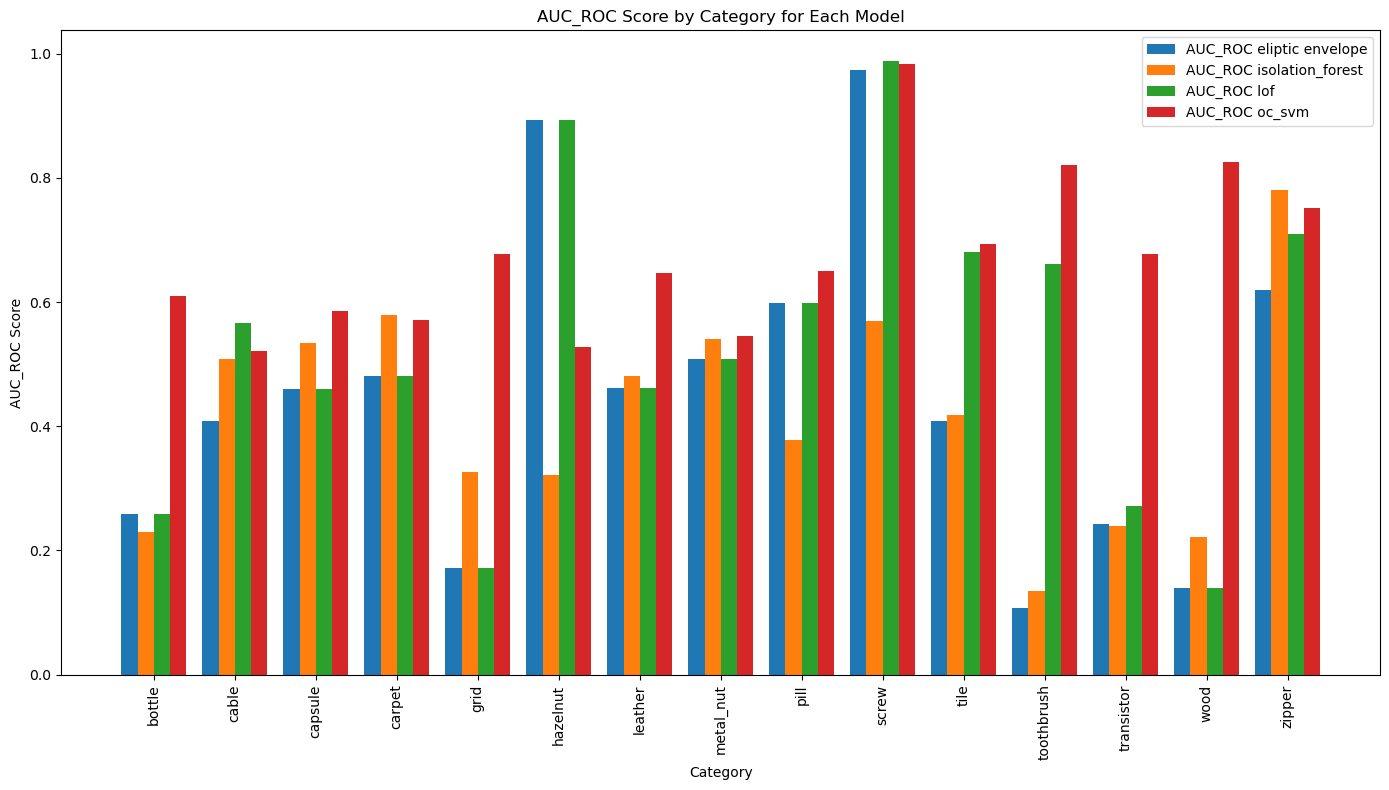

In [138]:
import numpy as np

import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(14, 8))

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r = np.arange(len(best_models_pivot.index))

# Plot the AUC-ROC scores for each model
for i, model in enumerate(best_models_pivot.columns):
    plt.bar(r + i * bar_width, best_models_pivot[model], width=bar_width, label=model)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('AUC_ROC Score')
plt.title('AUC_ROC Score by Category for Each Model')
plt.xticks(r + bar_width * (len(best_models_pivot.columns) - 1) / 2, best_models_pivot.index, rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


For almost all methods, we observe that oc_svm performs better

### **5.9. Finding the Best Models Based on AUC-ROC Scores**

- Computing the Best F1 Scores and Thresholds
- Initializes dictionaries to store the best F1 scores and validation scores.
- Iterates over each category to process its data.
- Retrieves the best model for each category.
- Extracts validation data and true labels.
- Calculates decision scores for anomaly detection models.
- Computes the mean and standard deviation of the decision scores.
- Generates 1000 threshold values within a range.
- Iterates through different thresholds to find the one that maximizes the F1 score.
- Stores the best F1 score and corresponding threshold for each model.
- Creates a DataFrame containing the best F1 scores, thresholds, AUC-ROC scores, and model parameters.


Thresold is always set to 0, since it is the one that gives the best results

In [139]:
from sklearn.metrics import f1_score

# Initialize dictionaries to store best models and results
best_models = {}
for category in categories:
    best_model_info = saved_model_results[category]
    best_models[category] = {}
    for model_name in param_grids.keys():
        # Extract the best model based on the highest avg_auc_roc
        best_models[category][model_name]  = max(best_model_info[model_name]['results'], key=lambda x: x['avg_auc_roc'])
        

# Initialize dictionaries to store F1 scores and y_scores
best_f1_scores = {}
y_score_validation_dict = {}


# Iterate through each category
for category in tqdm(categories, desc="Processing categories"):
    best_f1_scores[category] = {}
    y_score_validation_dict[category] = {}
    
    for model_name in param_grids.keys():
        # Get the best model for this category and method
        
        model = best_models[category][model_name]['model']
        
        # Get the validation data and true labels
        X_validation_pca = pca_validation_dfs[category].select_dtypes(include=[np.number]).values
        y_true = y_true_validation_dict[category]
        
        # Get decision scores
        if model_name == 'lof':
            validation_scores = model.decision_function(X_validation_pca)
        else:
            validation_scores = model.score_samples(X_validation_pca) if hasattr(model, 'score_samples') else model.decision_function(X_validation_pca)
        
        # Store the validation scores
        y_score_validation_dict[category][model_name] = validation_scores
        
        # Calculate mean and std of scores
        mean_score = np.mean(validation_scores)
        std_score = np.std(validation_scores)
        
        # Generate thresholds
        thresholds = np.linspace(mean_score - 1*std_score, mean_score + 1*std_score, 1000)
        
        # Initialize variables for best F1 score
        best_f1 = 0
        best_threshold = None
        
        # Iterate through thresholds
        for threshold in thresholds:
            # Get predictions based on threshold
            if model_name == 'lof':
                y_pred = (validation_scores <= threshold).astype(int)  # LOF flips the logic
            else:
                y_pred = (validation_scores >= threshold).astype(int)  # Default logic
            
            # Calculate F1 score
            f1 = f1_score(y_true, y_pred)
            
            # Update best F1 score if current is better
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Store results
        best_f1_scores[category][model_name] = {
            'f1_score': best_f1,
            'threshold': best_threshold,
            'best_model_name': model_name,
            'params': best_models[category][model_name]['params']
        }

# Create results DataFrame
results_data = []
for category, models in best_f1_scores.items():
    for model_name, scores in models.items():
        results_data.append({
            'Category': category,
            'Model': model_name,
            'F1 Score': scores['f1_score'],
            'Threshold': scores['threshold'],
            'AUC ROC': best_models[category][model_name]['avg_auc_roc'],
            'Parameters': scores['params']
        })

results_df_2 = pd.DataFrame(results_data)


Processing categories: 100%|██████████| 15/15 [00:00<00:00, 18.99it/s]


In [140]:
results_df_2

,Category,Model,F1 Score,Threshold,AUC ROC,Parameters
0,bottle,oc_svm,0.863636,0,0.610043,"{'degree': 2, 'gamma': 'auto', 'kernel': 'poly..."
1,bottle,isolation_forest,0.000000,0,0.228632,"{'contamination': 0.01, 'max_features': 1.0, '..."
2,bottle,lof,0.448980,0,0.258013,"{'algorithm': 'auto', 'contamination': 0.01, '..."
3,bottle,eliptic envelope,0.000000,0,0.258013,"{'assume_centered': True, 'contamination': 0.0..."
4,cable,oc_svm,0.516854,0,0.520505,"{'degree': 2, 'gamma': 'scale', 'kernel': 'lin..."
5,cable,isolation_forest,0.000000,0,0.508159,"{'contamination': 0.01, 'max_features': 1.0, '..."
6,cable,lof,0.000000,0,0.566233,"{'algorithm': 'auto', 'contamination': 0.01, '..."
7,cable,eliptic envelope,0.000000,0,0.408042,"{'assume_centered': True, 'contamination': 0.0..."
8,capsule,oc_svm,0.835821,0,0.586351,"{'degree': 3, 'gamma': 'auto', 'kernel': 'poly..."
9,capsule,isolation_forest,0.000000,0,0.534265,"{'contamination': 0.01, 'max_features': 1.0, '..."


## *6. Plotting ROC Curve and Confusion Matrices*
- Defines anomaly detection methods.

- Initializes dictionaries for storing test scores and AUC-ROC values.
- Sets up subplots for visualizing ROC curves.

- Uses ravel() to flatten the axes array for easy indexing.

- Computes the False Positive Rate (FPR), True Positive Rate (TPR), and AUC-ROC score.
- Plots the ROC curve for each category.
- Creates subplots for confusion matrices.
- Generates and visualizes confusion matrices.






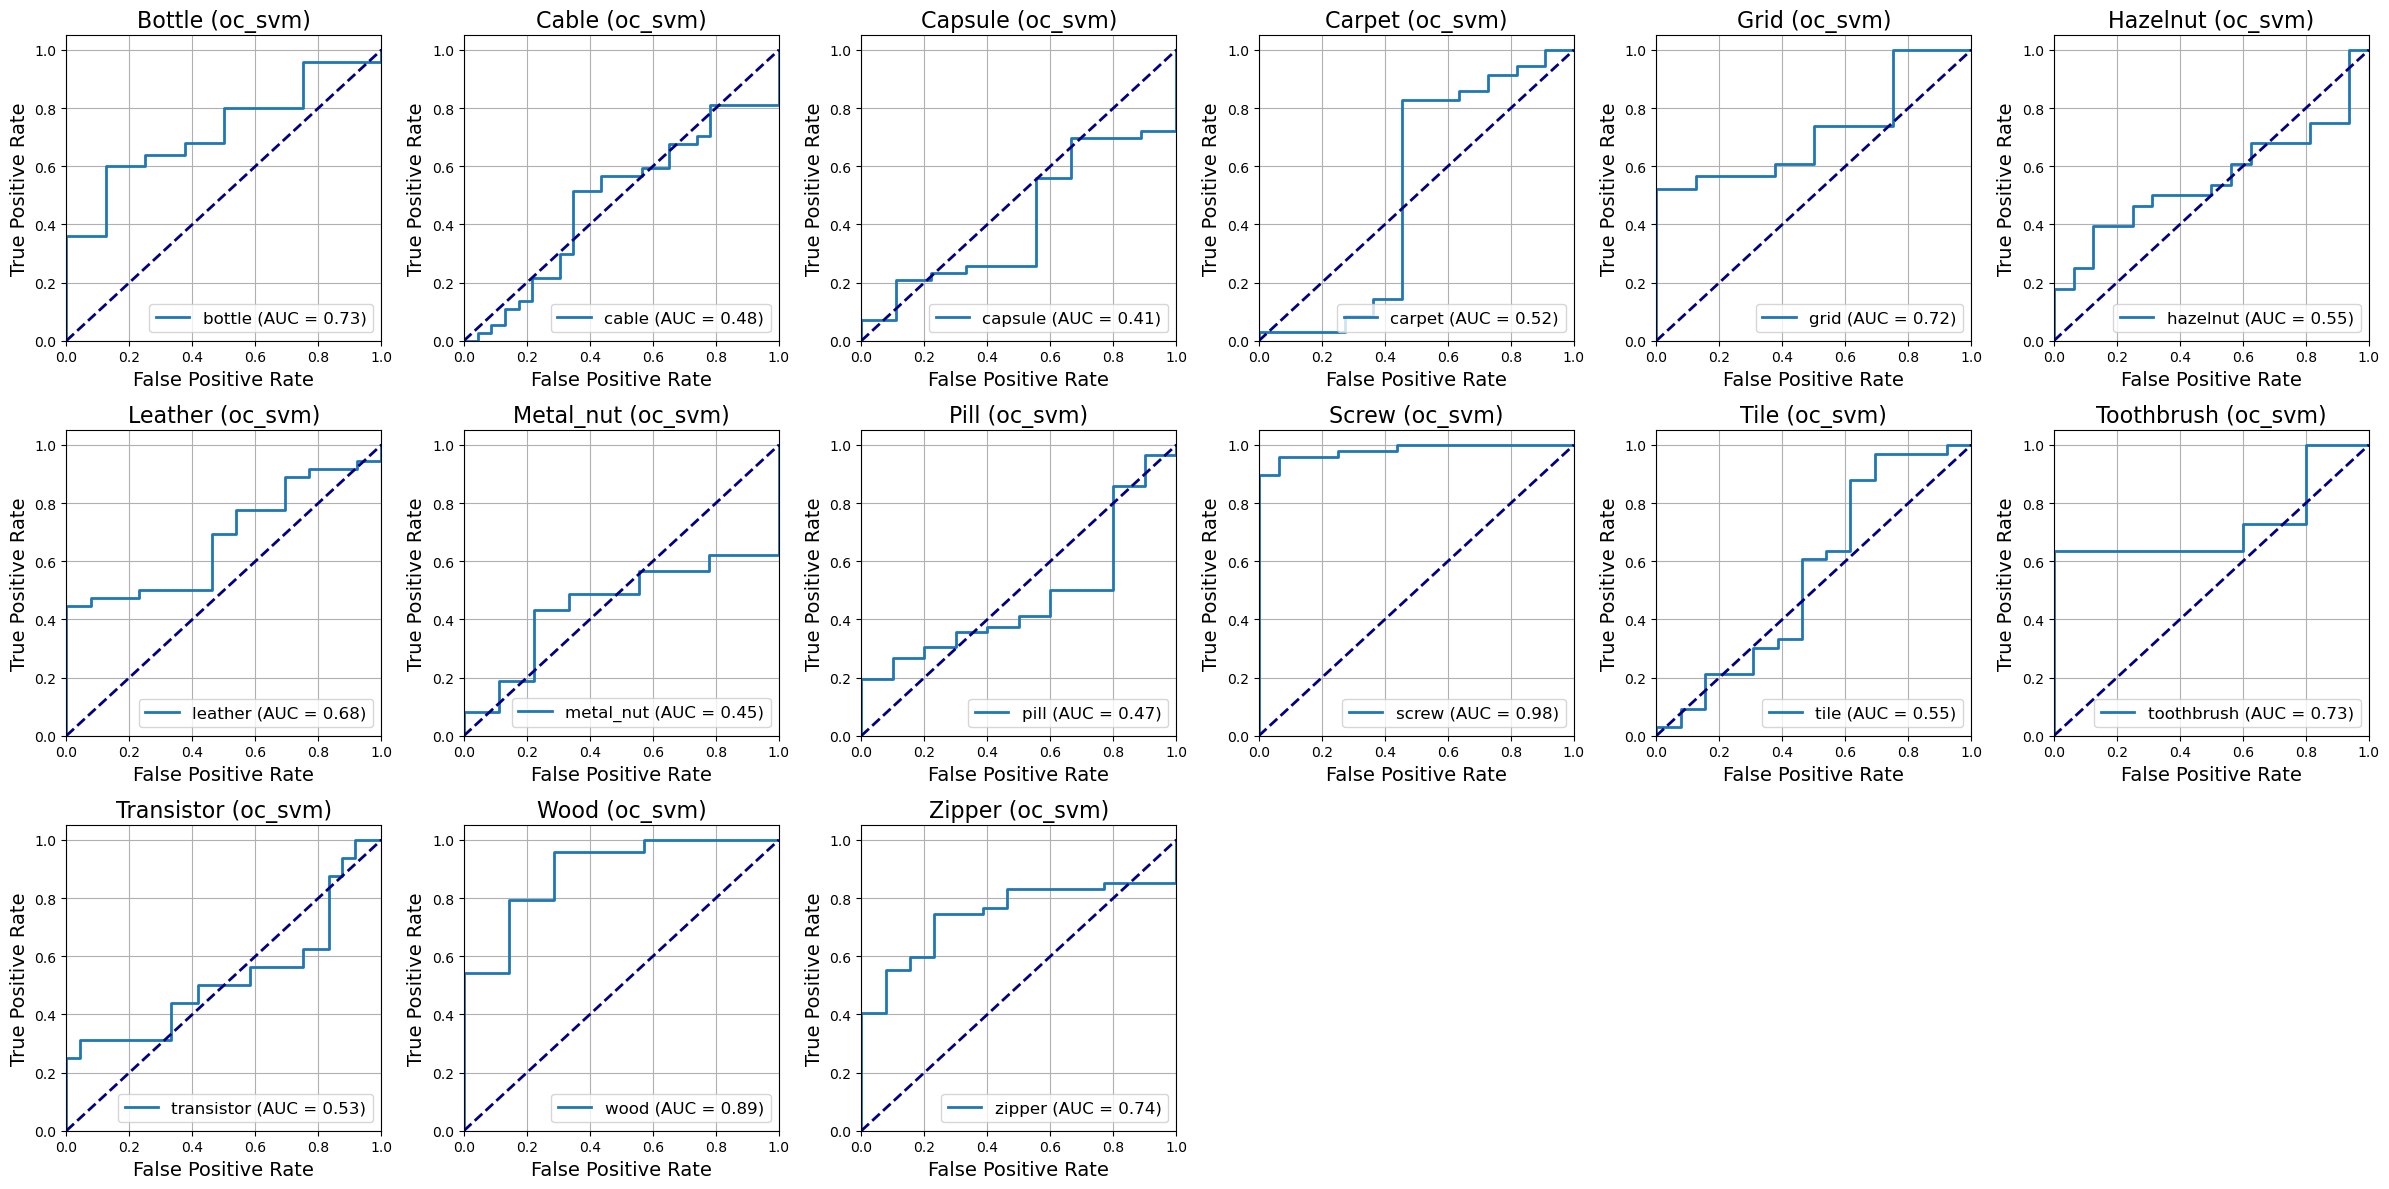

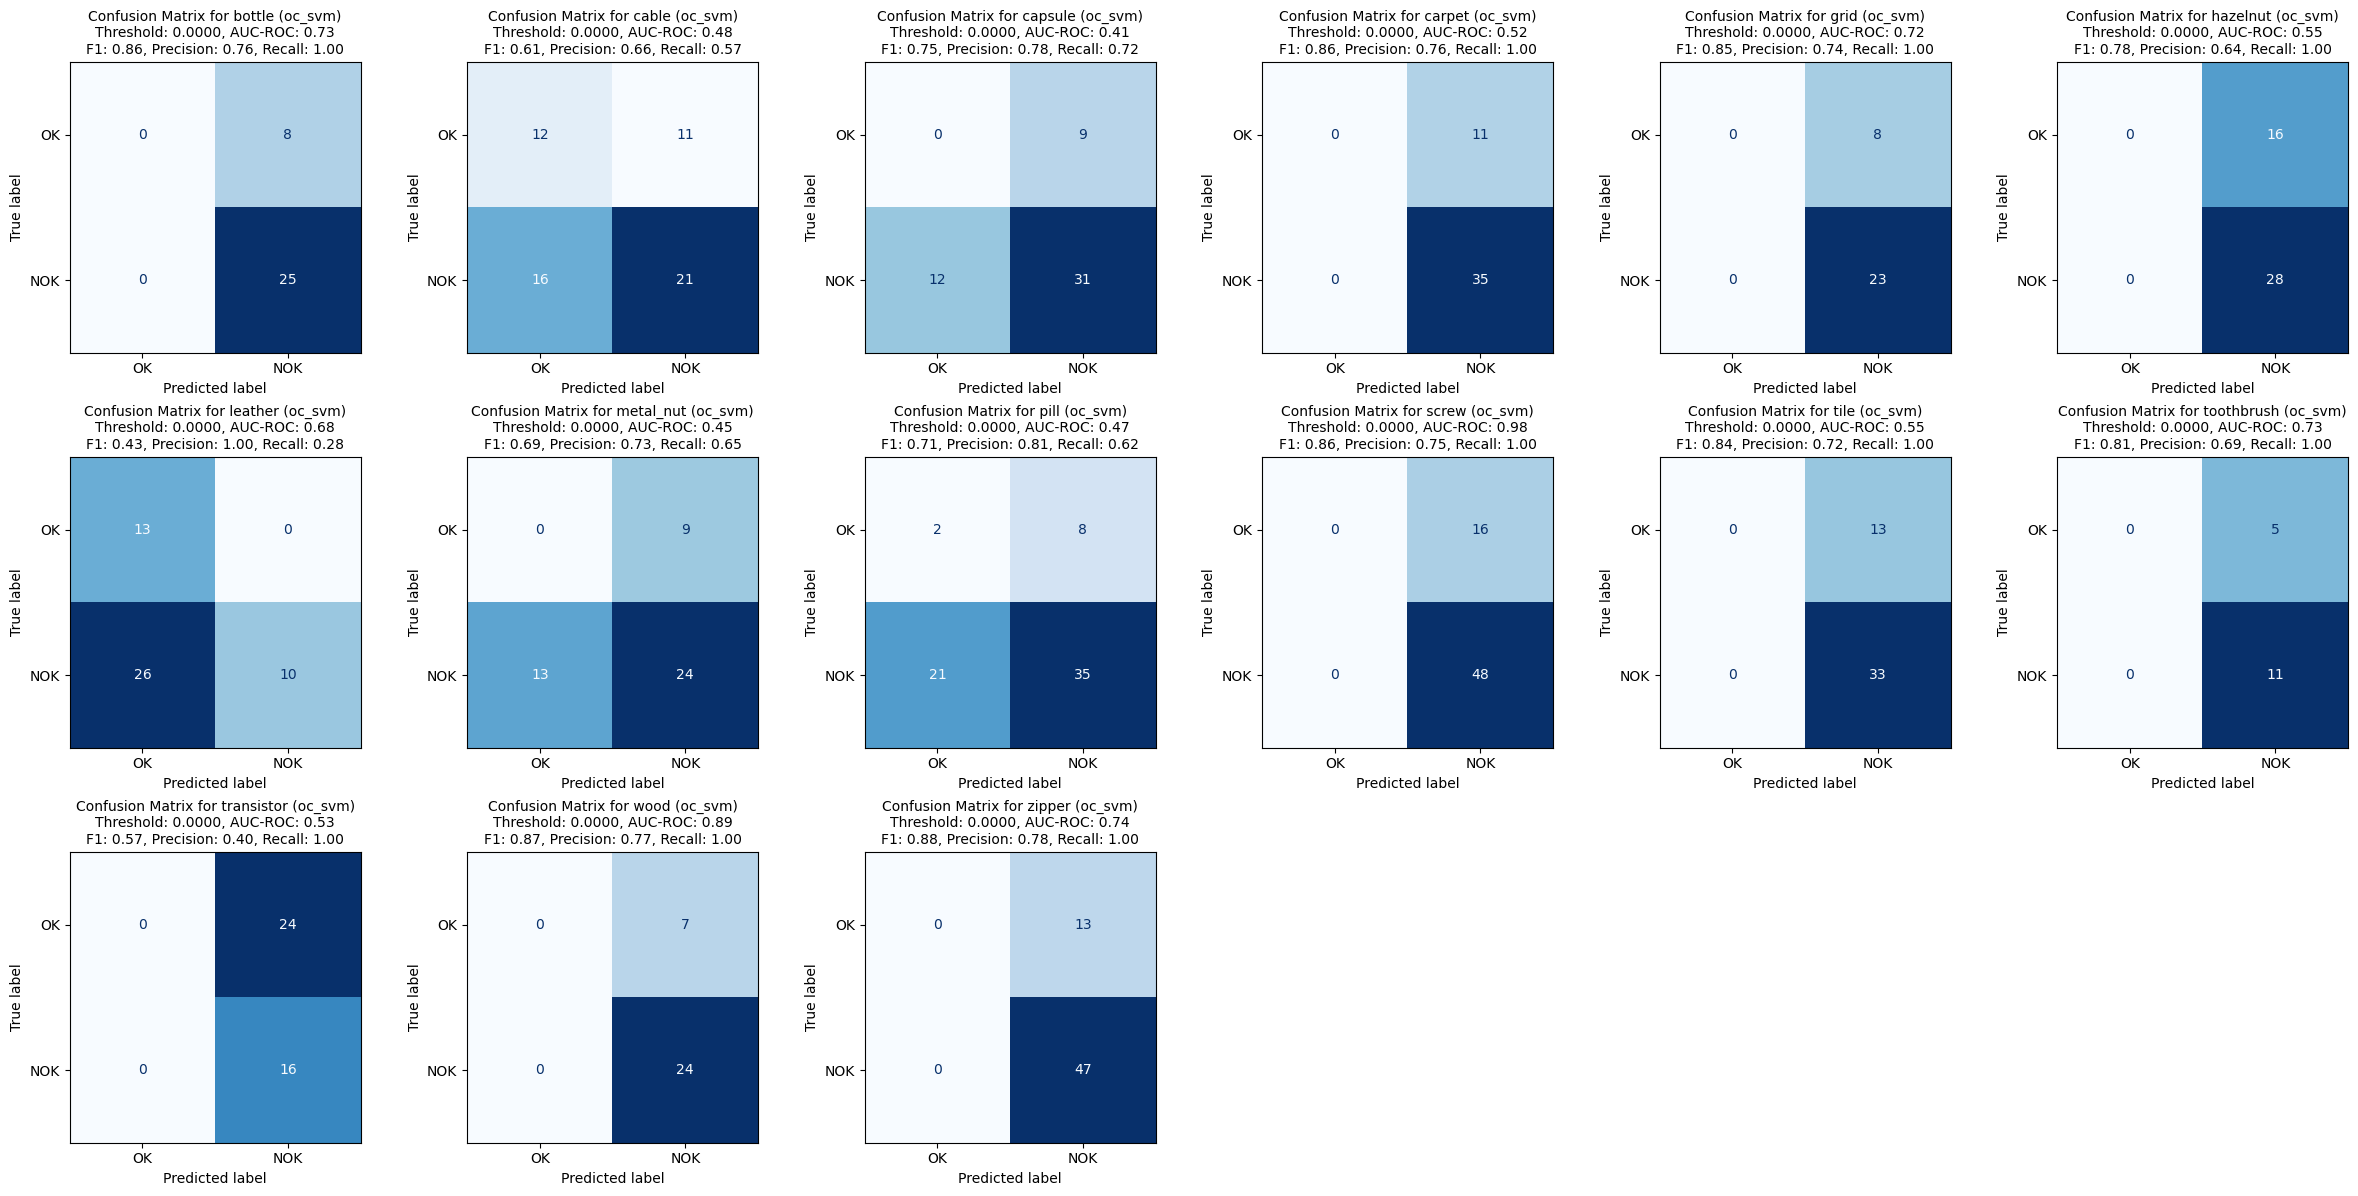

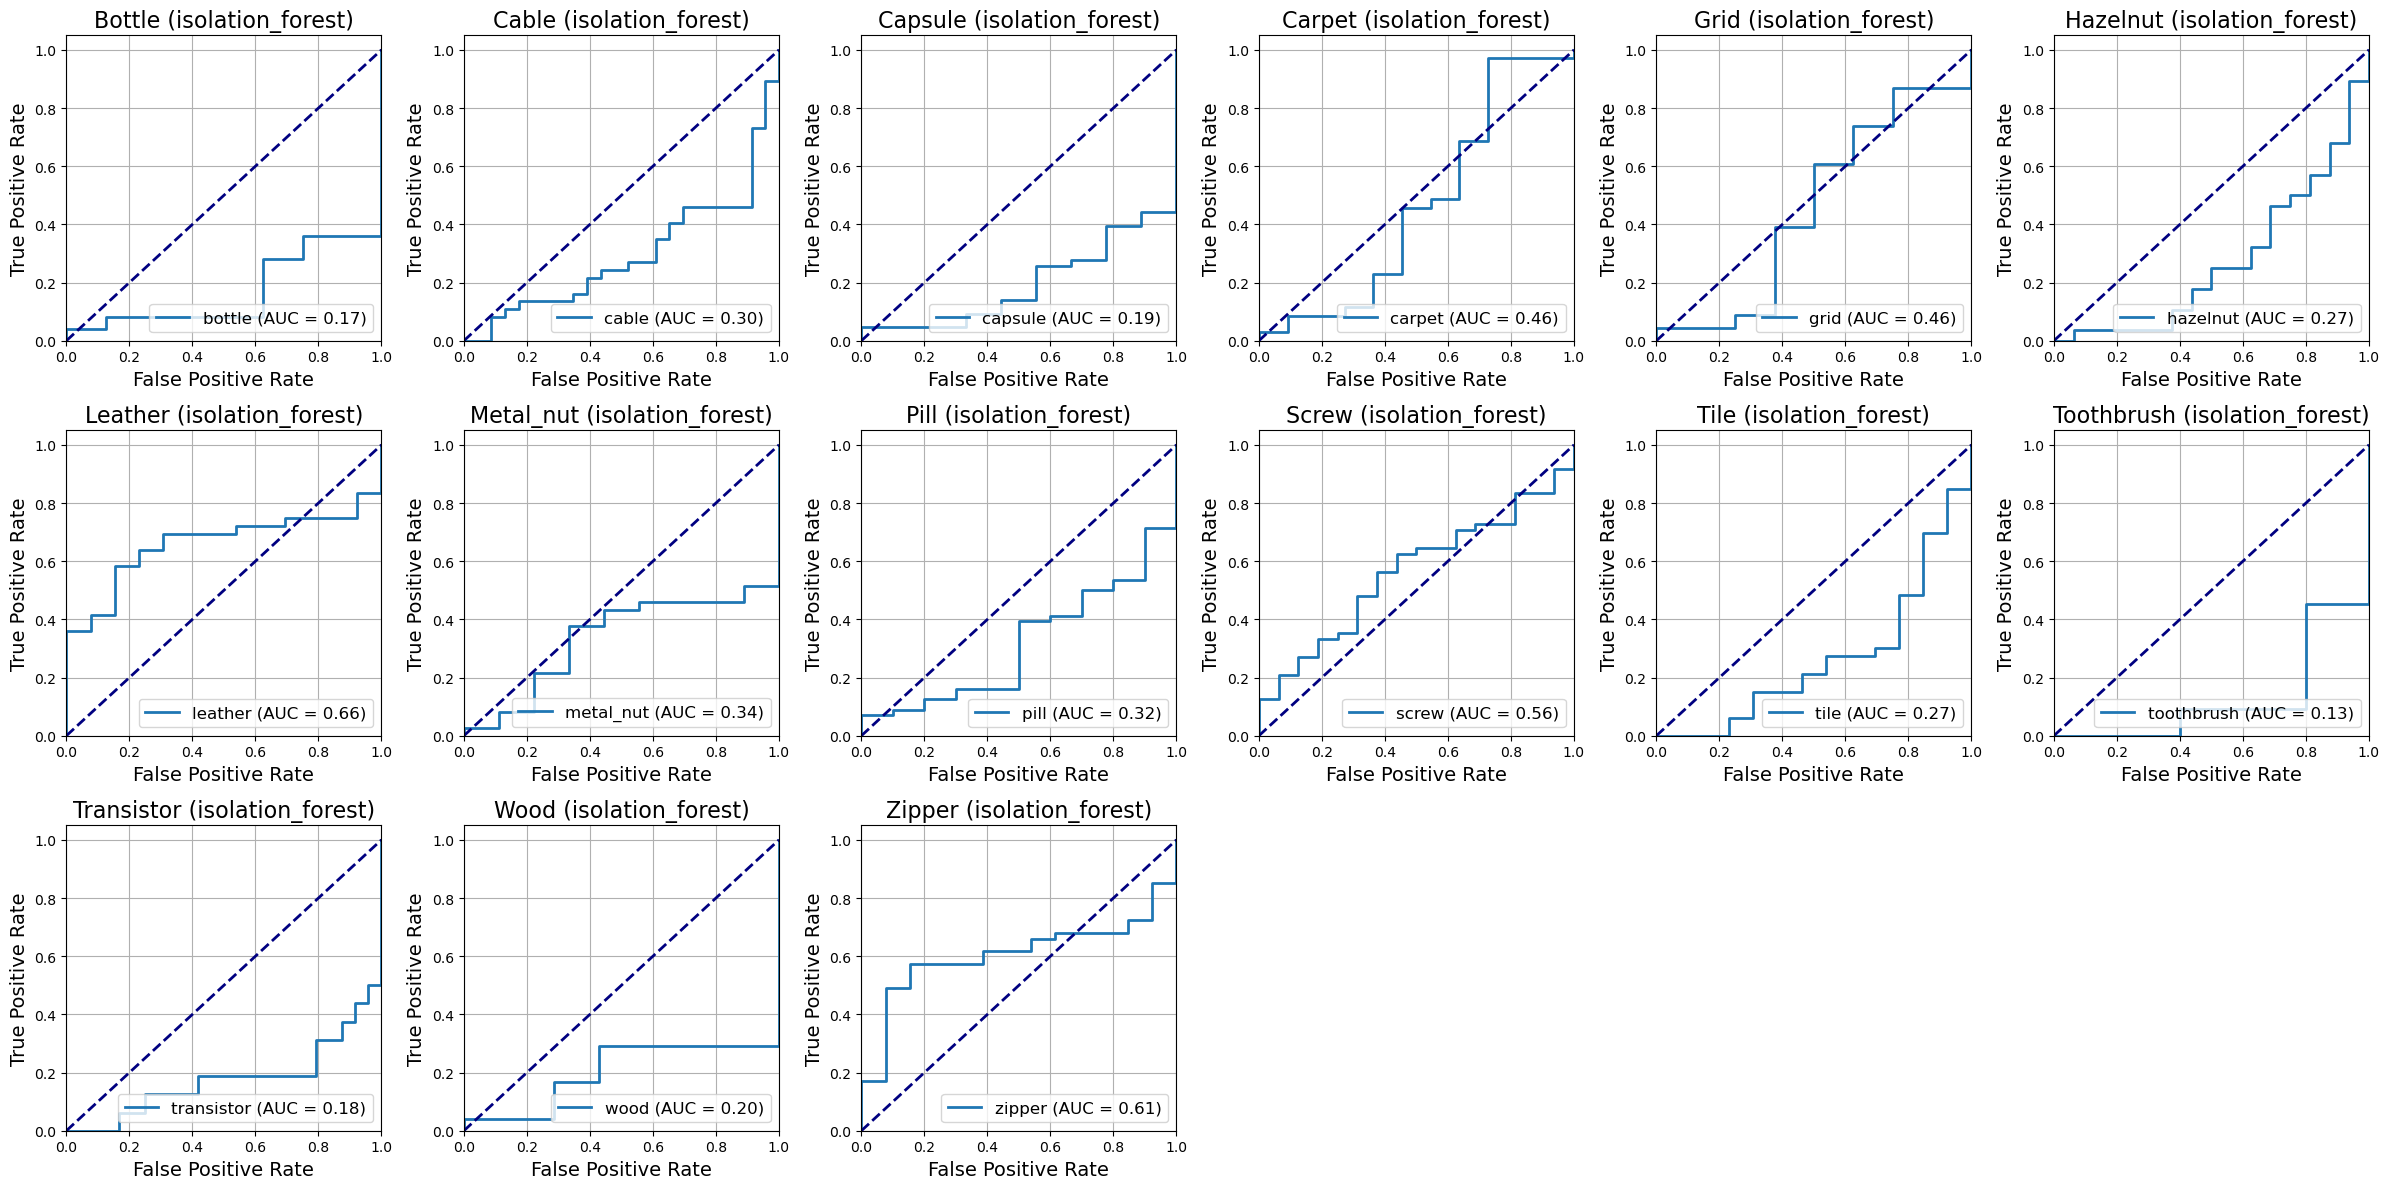

c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

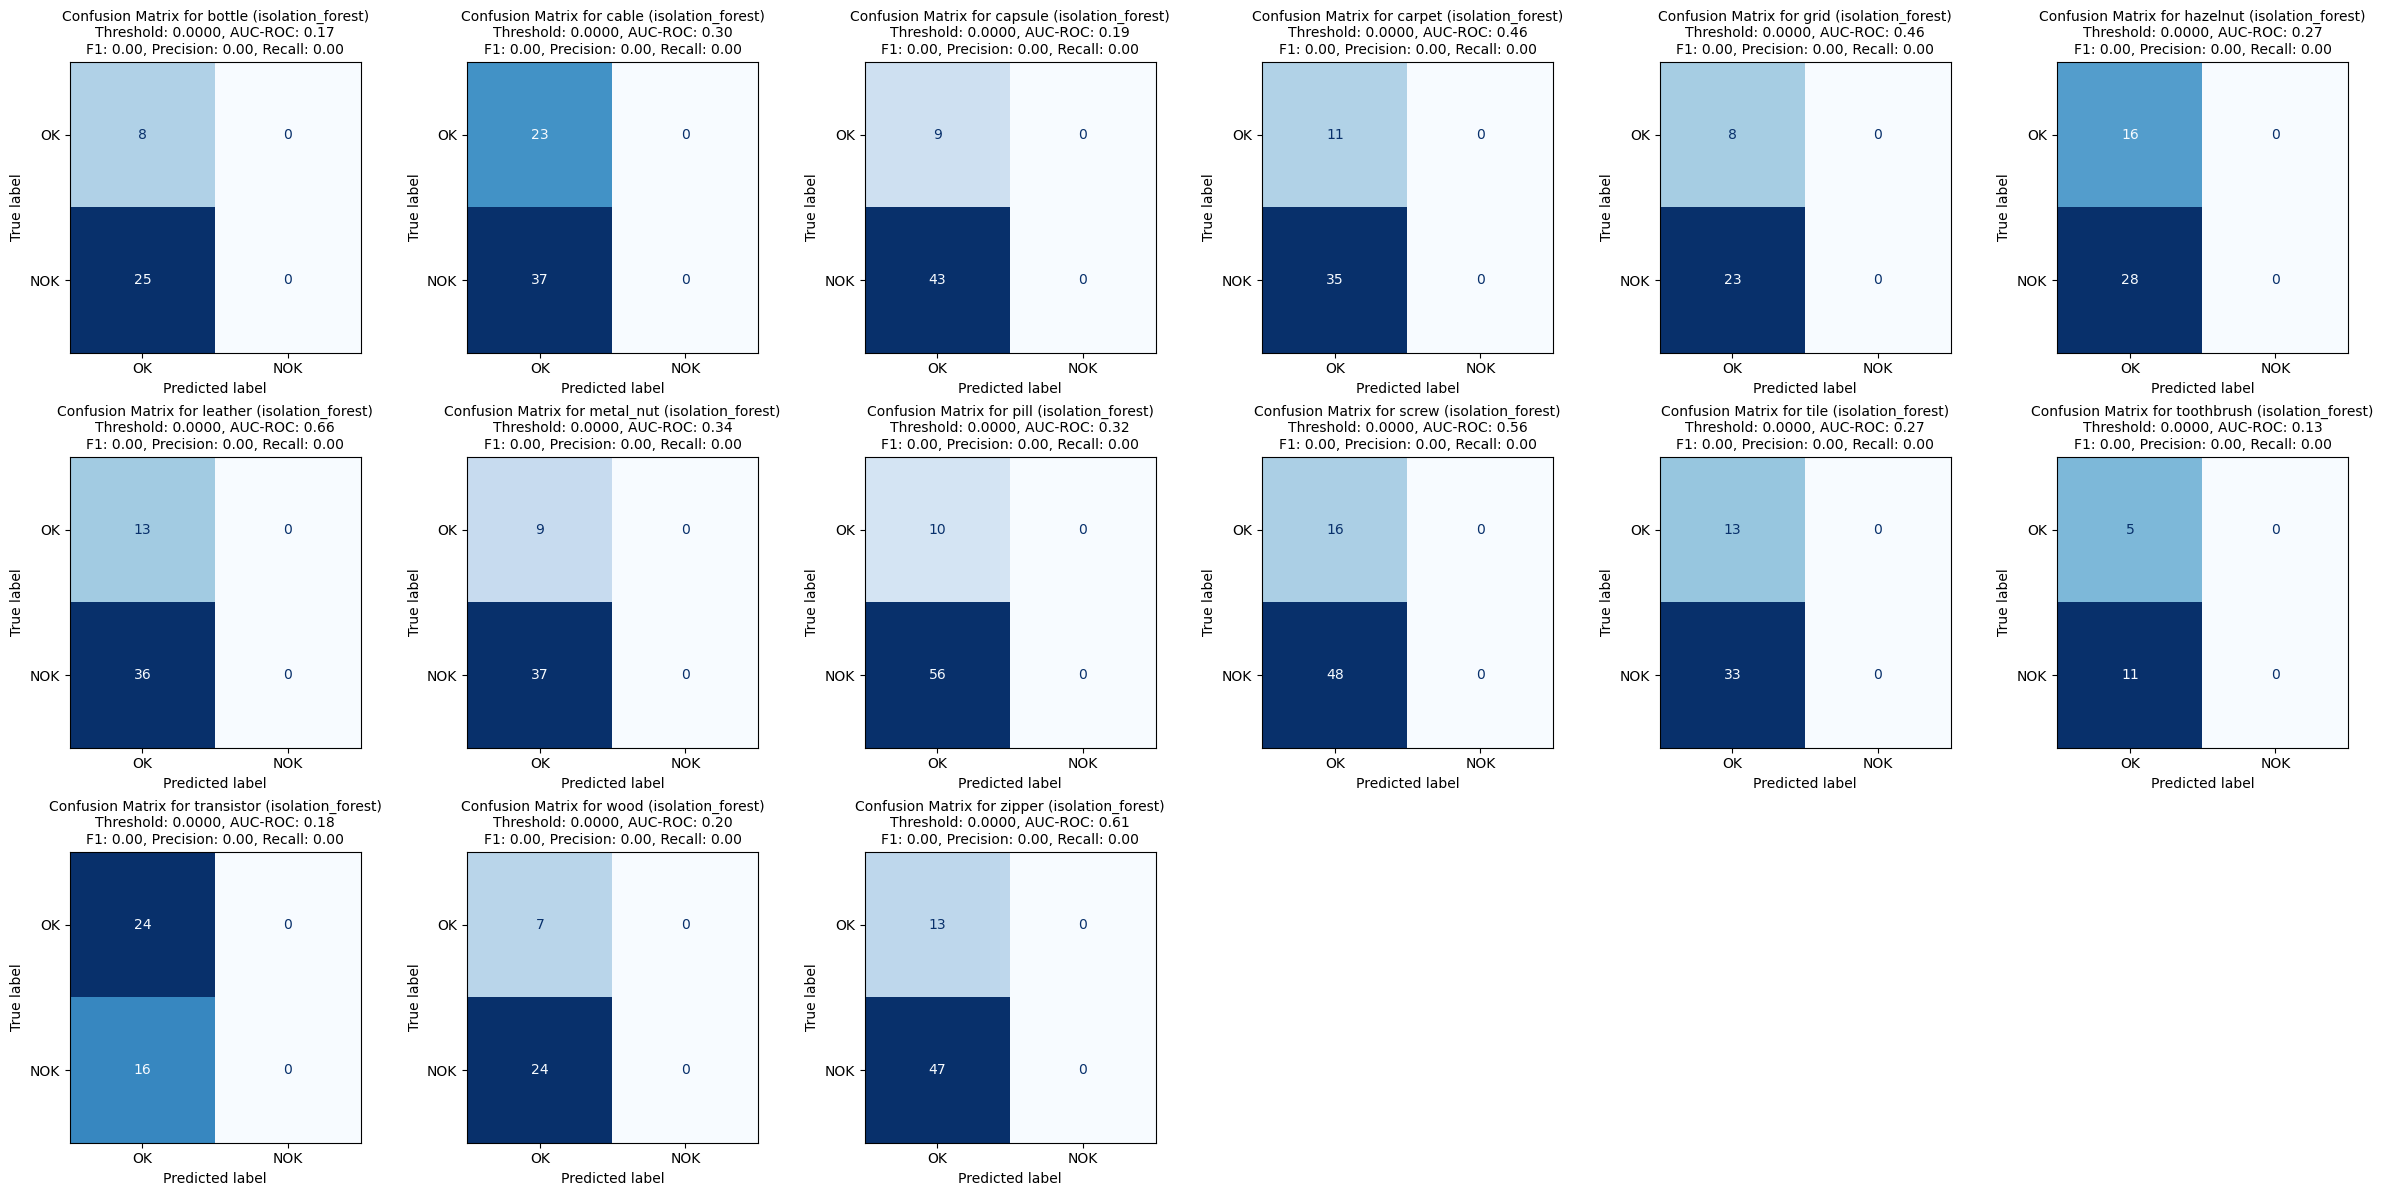

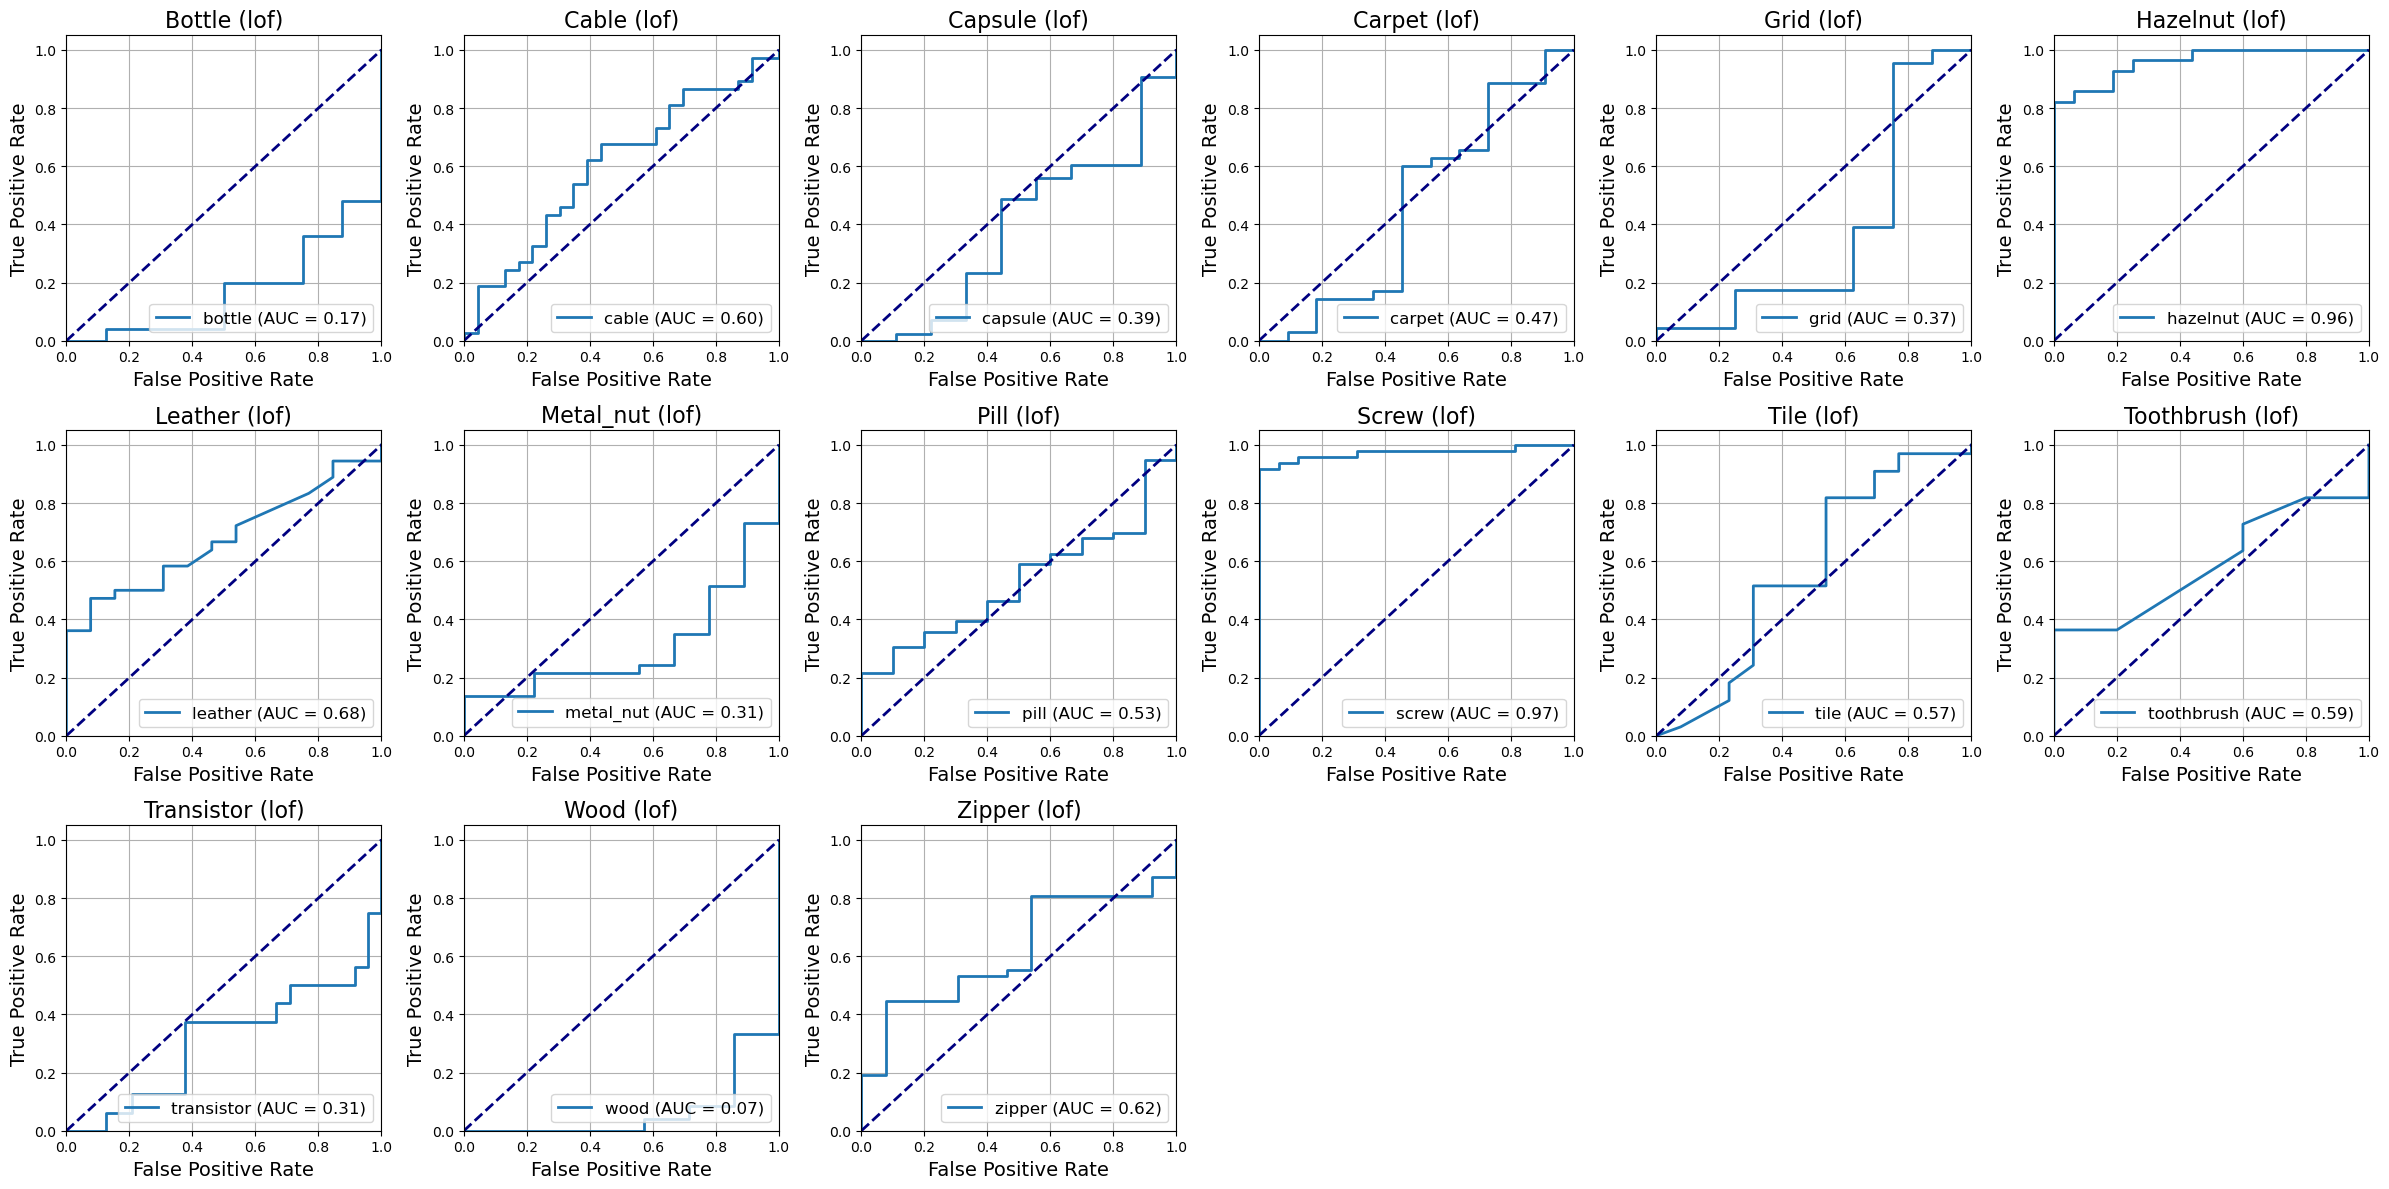

c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

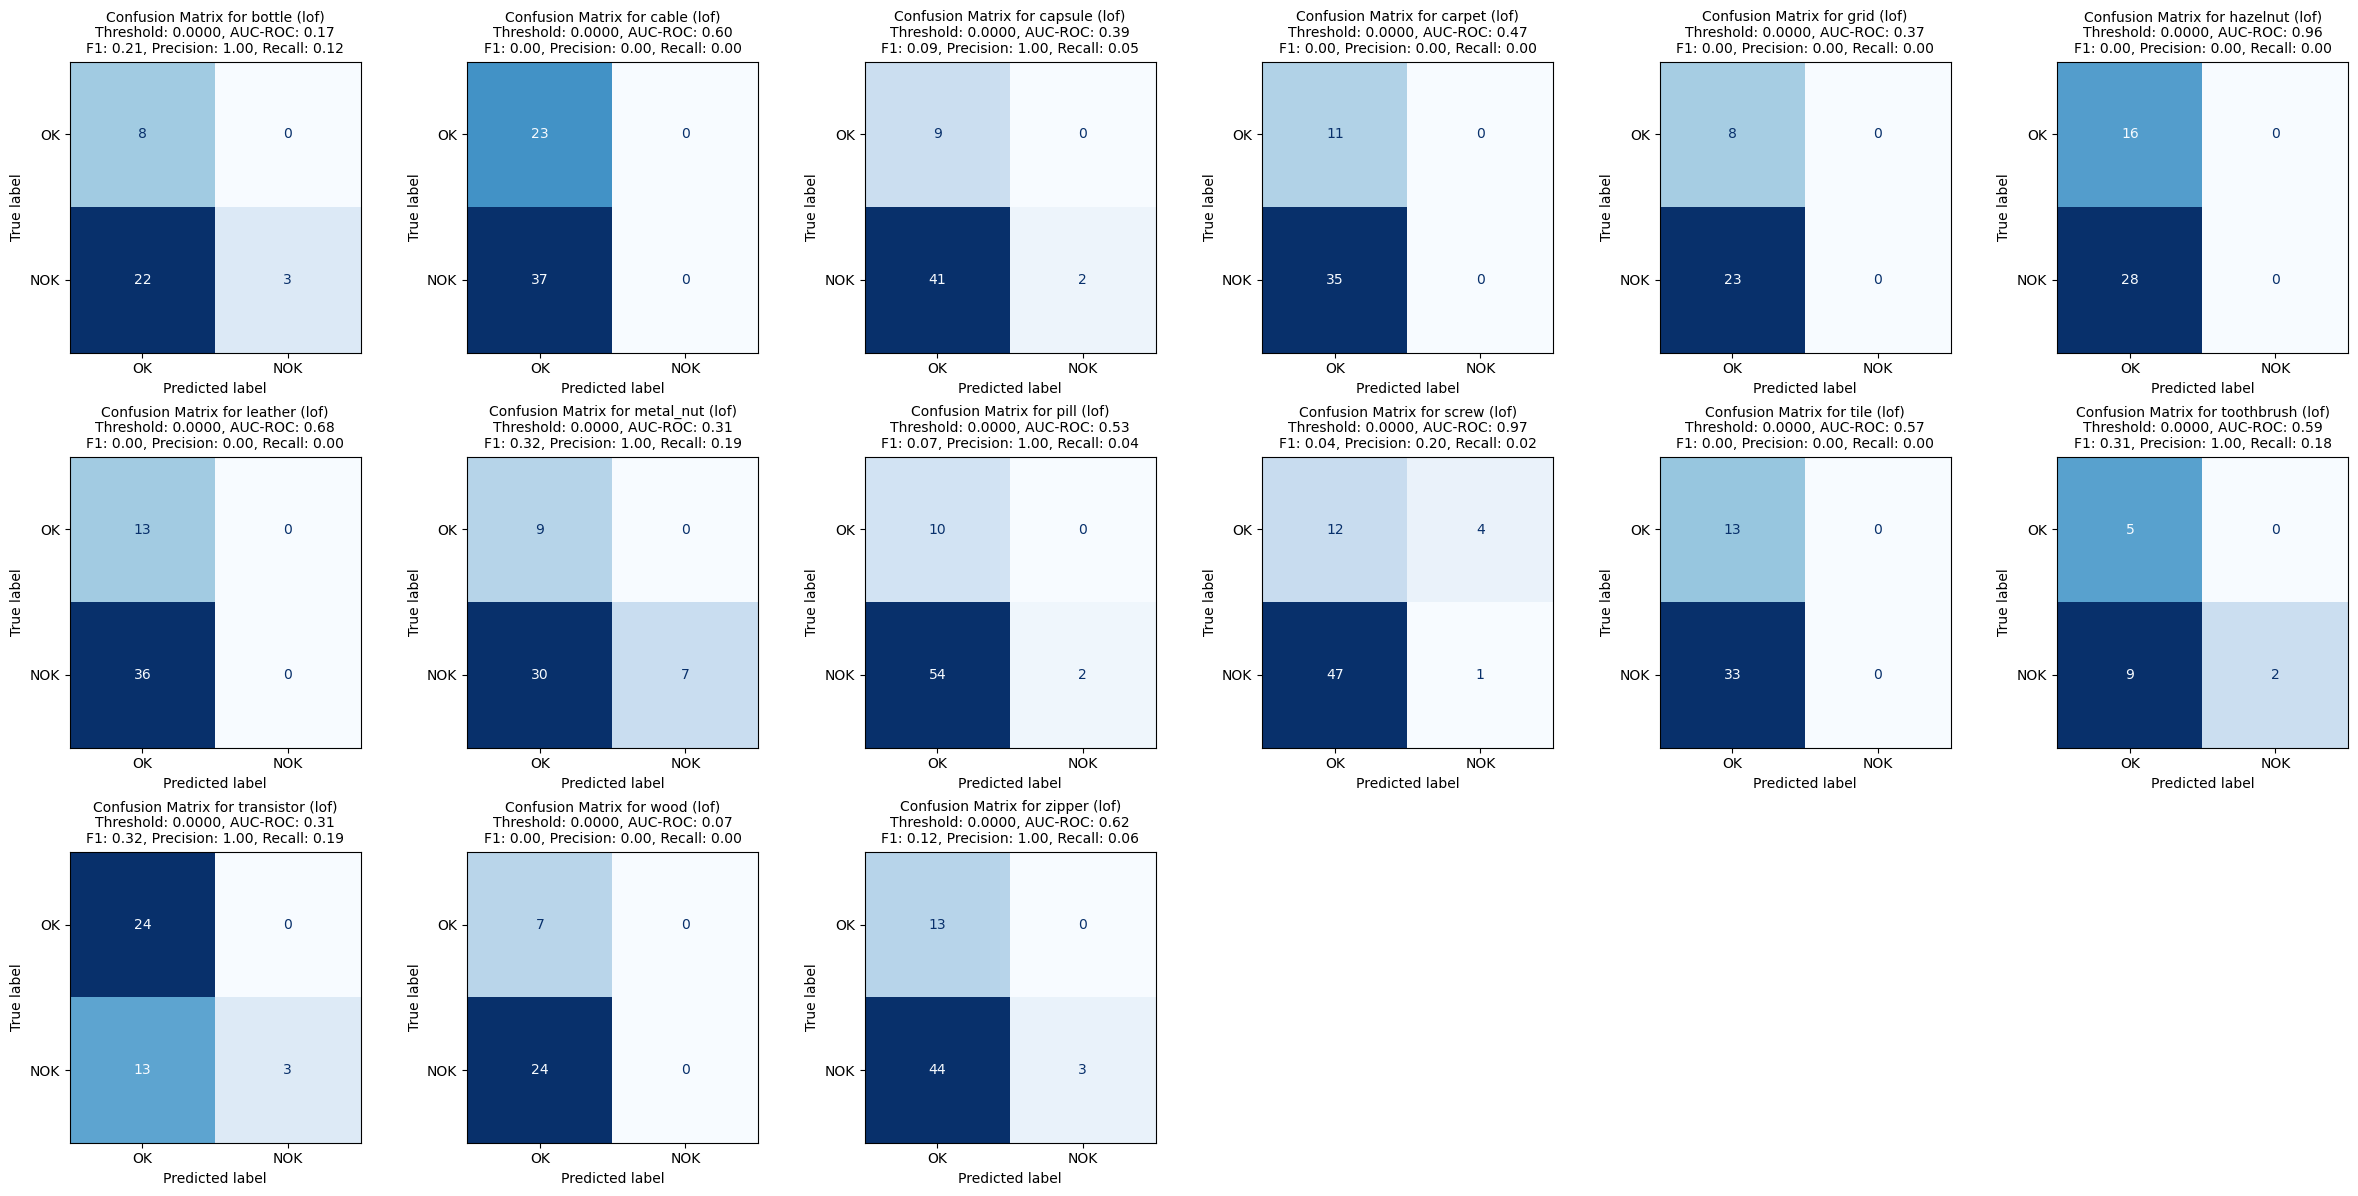

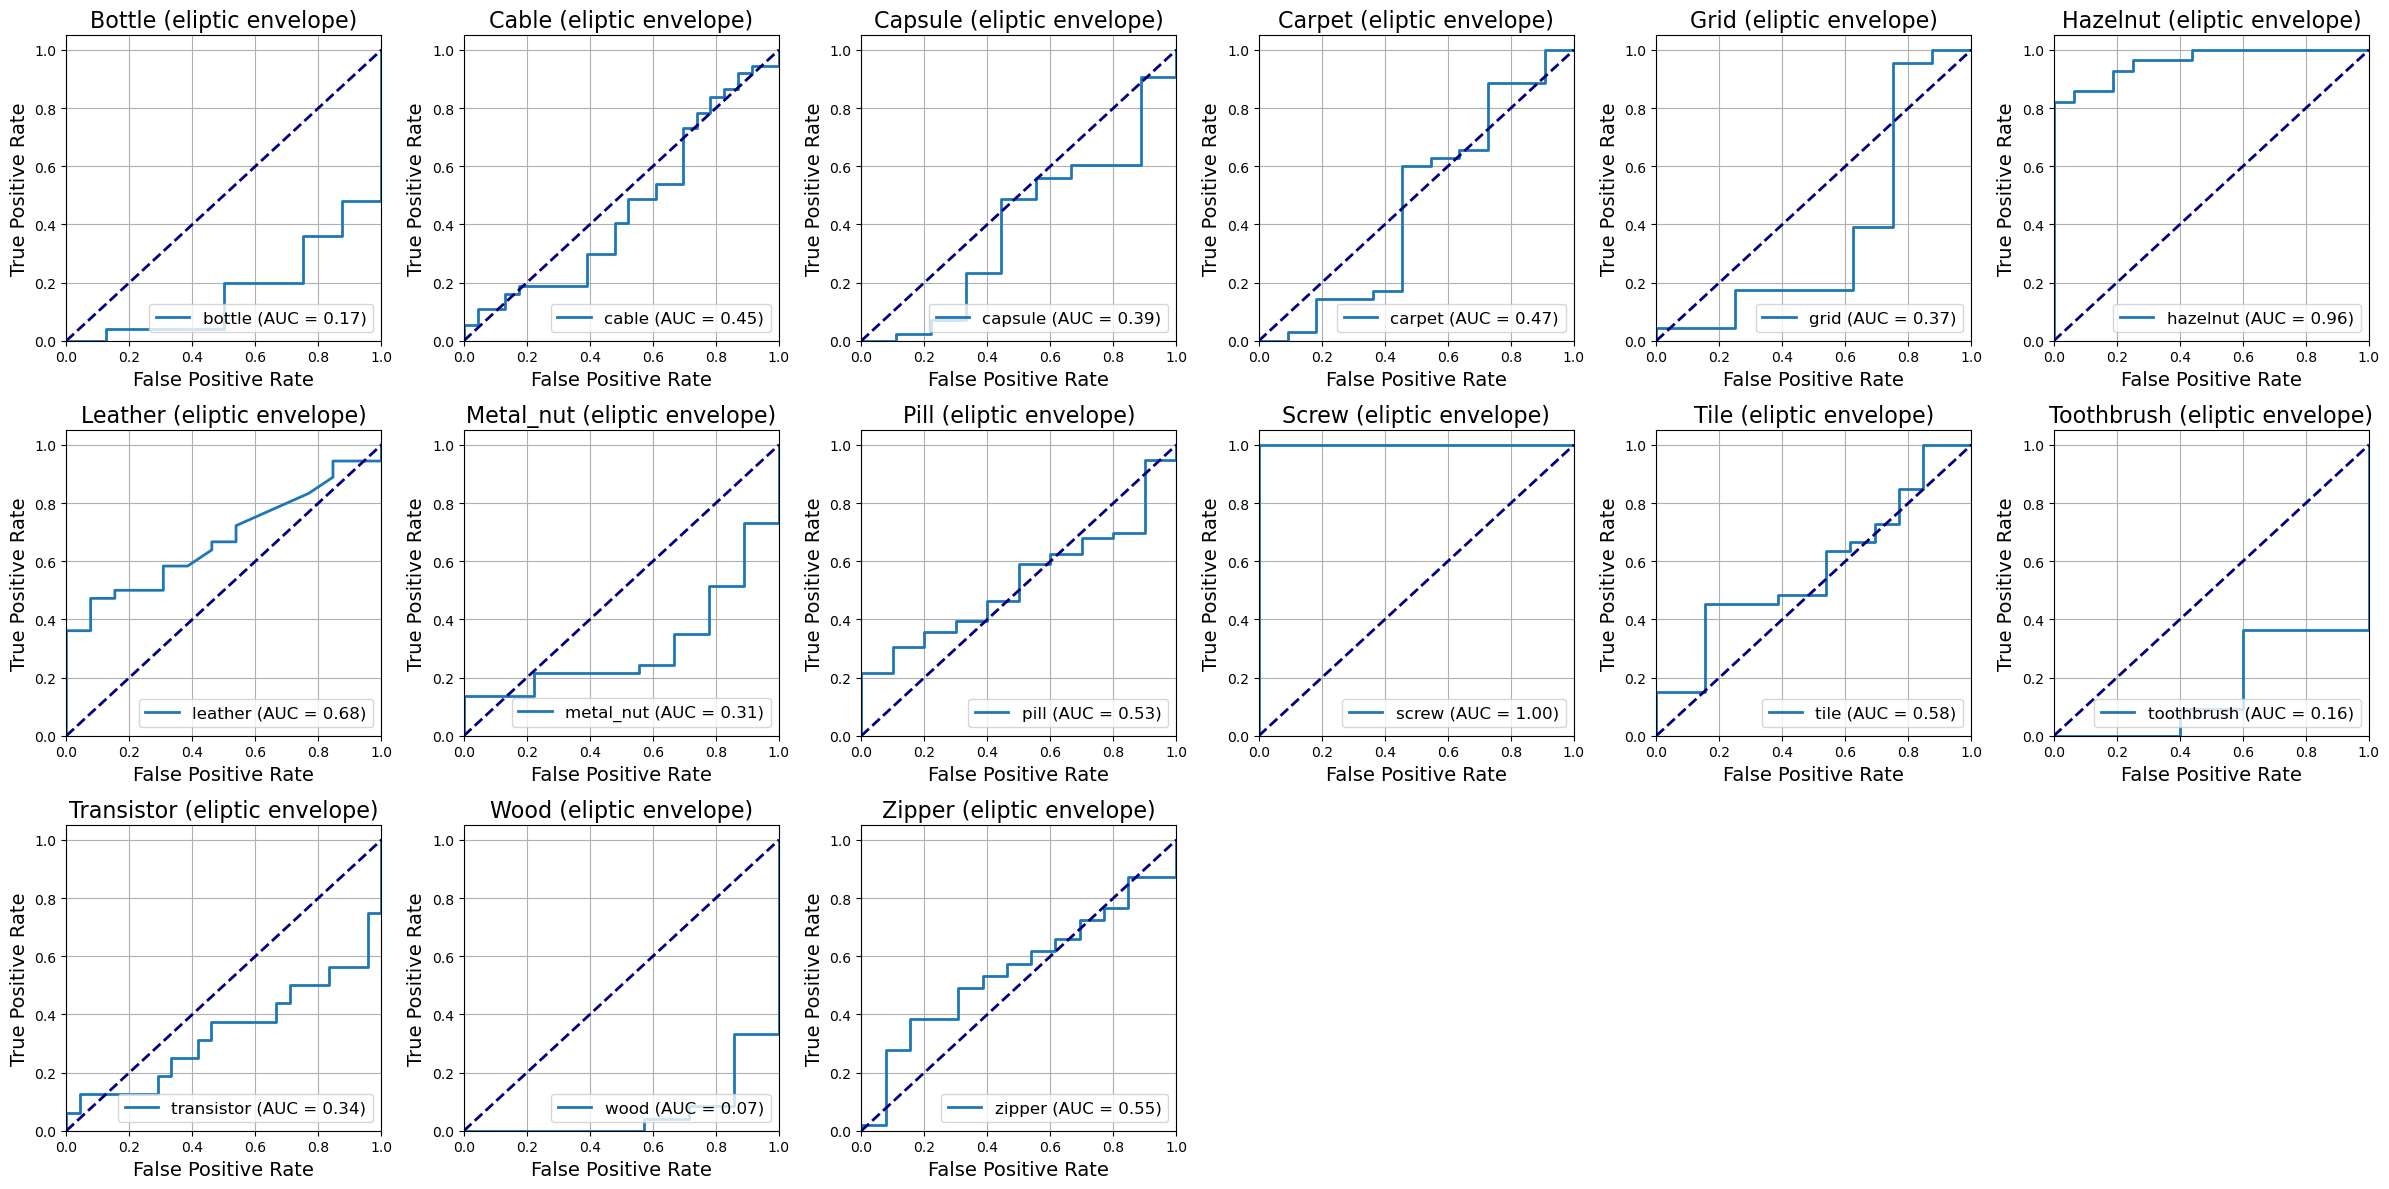

c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\peppe\anaconda3\envs\MVTEC_torch_py310_20250114\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

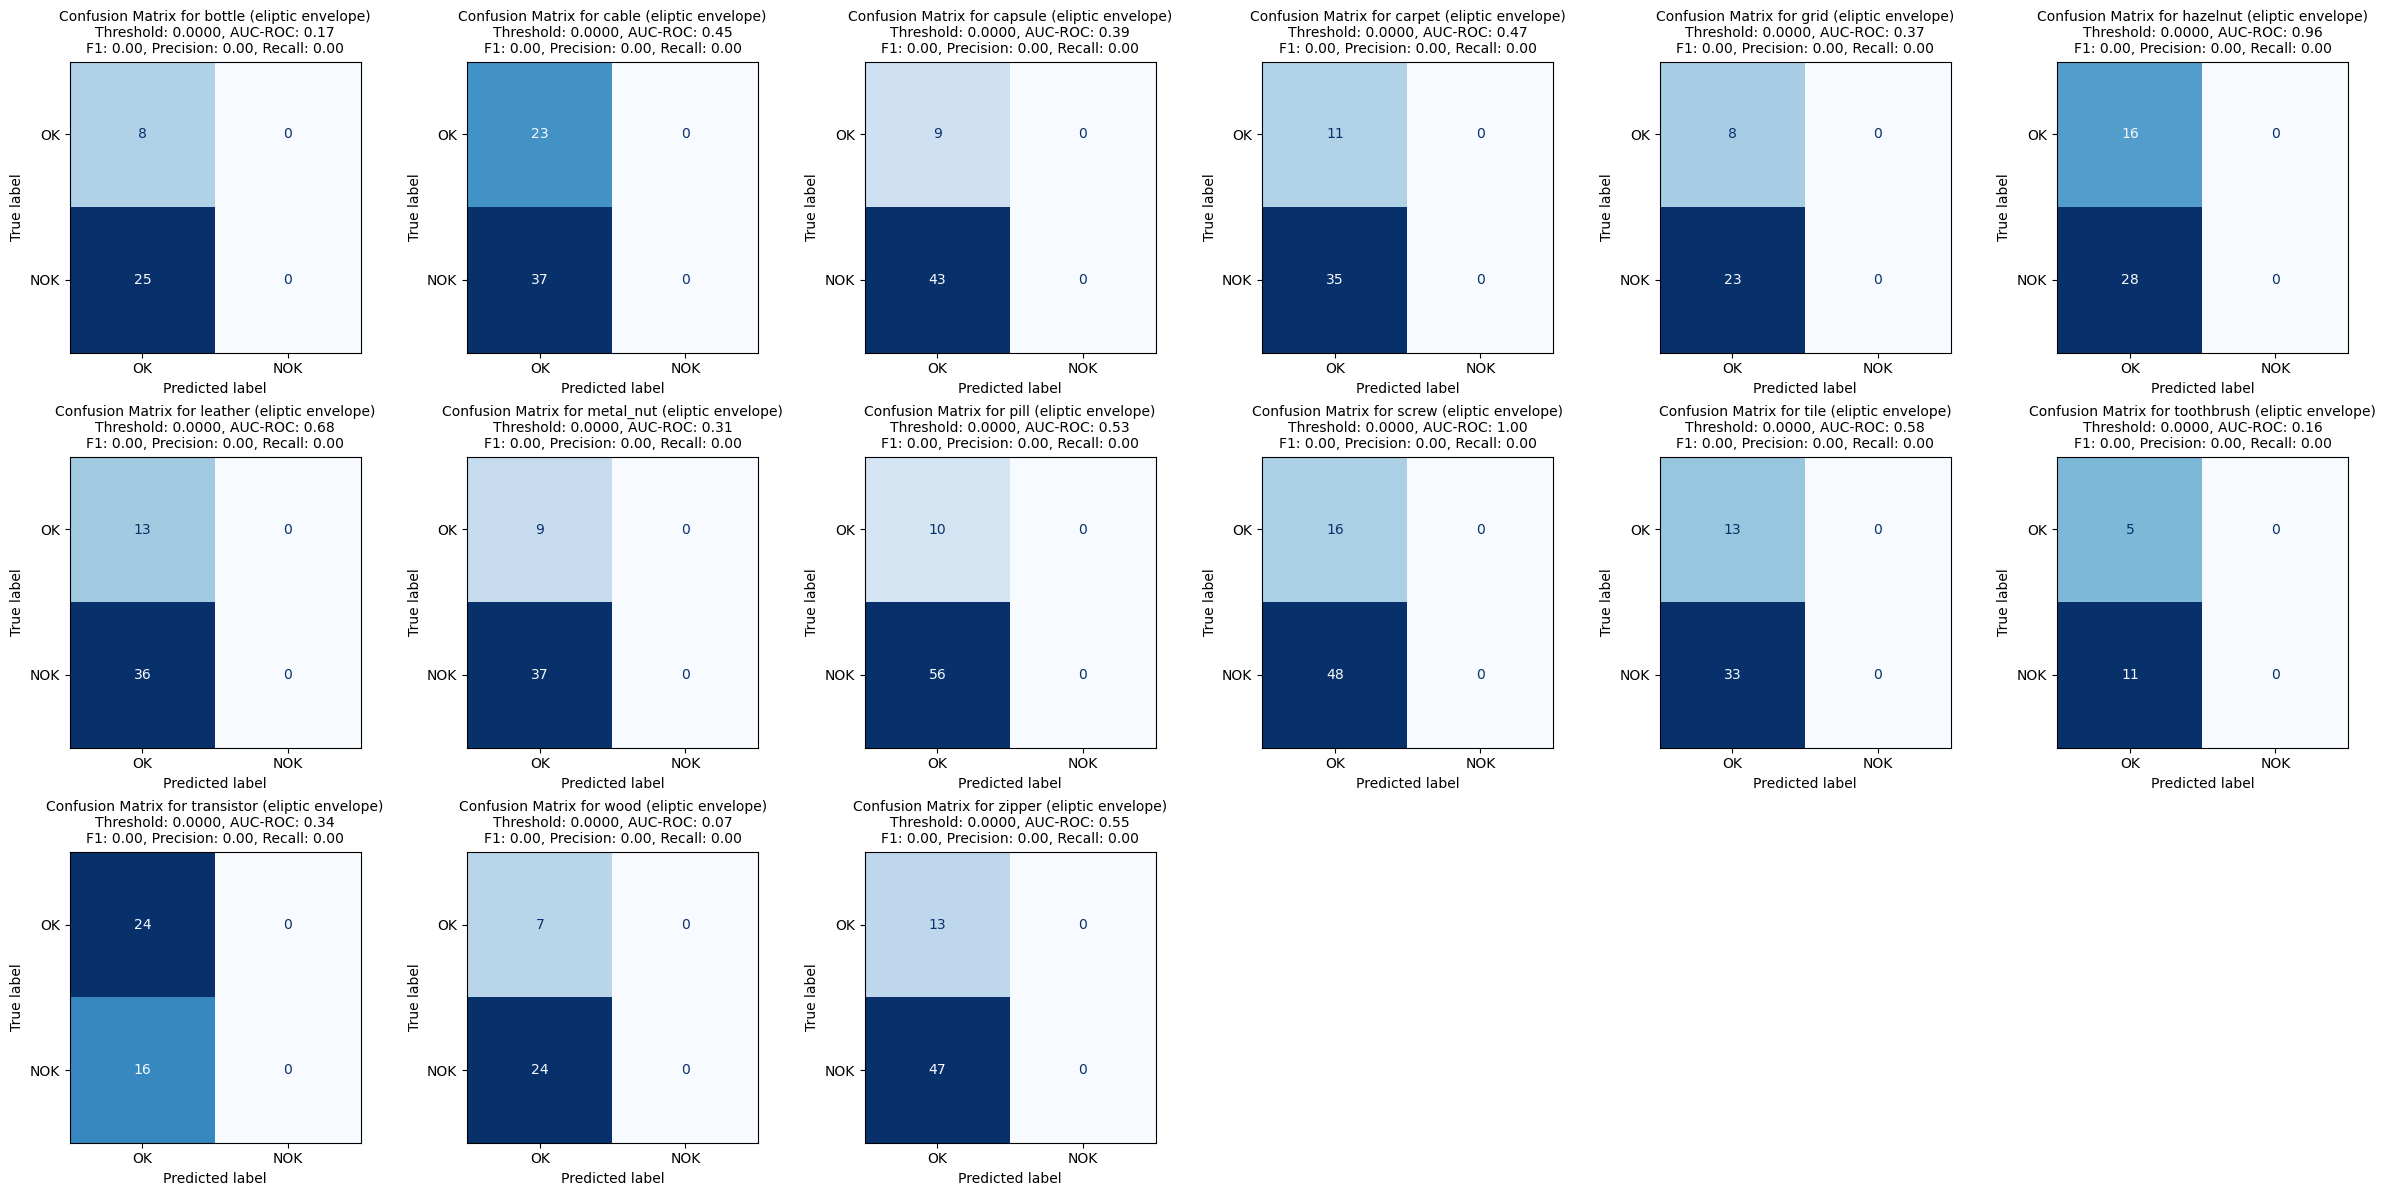

In [141]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

methods = ['oc_svm', 'isolation_forest', 'lof', 'eliptic envelope']

# Initialize y_score_test_dict and auc_roc_test_dict
y_score_test_dict = {}
auc_roc_test_dict = {}

for method in methods:
    # Initialize the plot for ROC curves
    fig, axes = plt.subplots(3, 6, figsize=(24, 12))
    axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

    # Dictionary to store ROC AUC scores
    roc_auc_scores = {}

    # Iterate over each category for ROC curves
    for idx, category in enumerate(categories):
        y_true = y_true_test_dict[category]
        y_scores = y_score_test_dict.get(category, {}).get(method, None)

        if y_scores is None:
            # Calculate y_scores if not already present
            model = best_models[category][method]['model']
            X_test_pca = pca_test_dfs[category].drop(columns=['category']).values
            if method == 'lof':
                y_scores = model.decision_function(X_test_pca)
            else:
                y_scores = model.score_samples(X_test_pca) if hasattr(model, 'score_samples') else model.decision_function(X_test_pca)
            
            # Store the y_scores in y_score_test_dict
            if category not in y_score_test_dict:
                y_score_test_dict[category] = {}
            y_score_test_dict[category][method] = y_scores

        if y_scores is not None:
            # Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            # Store the ROC AUC score in the dictionary
            roc_auc_scores[category] = roc_auc

            # Plot the ROC curve
            axes[idx].plot(fpr, tpr, lw=2, label=f'{category} (AUC = {roc_auc:.2f})')

        # Plot the diagonal line for random chance
        axes[idx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        # Configure plot settings
        axes[idx].set_xlim([0.0, 1.0])
        axes[idx].set_ylim([0.0, 1.05])
        axes[idx].set_xlabel('False Positive Rate', fontsize=14)
        axes[idx].set_ylabel('True Positive Rate', fontsize=14)
        axes[idx].set_title(f'{category.capitalize()} ({method})', fontsize=16)
        axes[idx].legend(loc='lower right', fontsize=12)
        axes[idx].grid(True)

    # Remove empty subplots if any
    for idx in range(len(categories), 18):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    # Initialize the plot for confusion matrices
    fig, axes_cm = plt.subplots(3, 6, figsize=(24, 12))
    axes_cm = axes_cm.ravel()  # Flatten the 2D array of axes for easier indexing

    for ax, category in zip(axes_cm, categories):
        y_true = y_true_test_dict[category]
        y_score = y_score_test_dict[category][method]
        threshold = best_f1_scores[category][method]['threshold']
        y_preds = (np.array(y_score) >= threshold).astype(int) if method != 'lof' else (np.array(y_score) <= threshold).astype(int)

        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_preds)

        # Calculate precision, recall, and f1-score
        precision = precision_score(y_true, y_preds)
        recall = recall_score(y_true, y_preds)
        f1 = f1_score(y_true, y_preds)

        # Calculate AUC-ROC score
        roc_auc = roc_auc_scores[category]

        # Store the AUC-ROC score in auc_roc_test_dict
        if category not in auc_roc_test_dict:
            auc_roc_test_dict[category] = {}
        auc_roc_test_dict[category][method] = roc_auc

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OK', 'NOK'])
        disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
        ax.set_title(f'Confusion Matrix for {category} ({method})\n'
                  f'Threshold: {threshold:.4f}, AUC-ROC: {roc_auc:.2f}\n'
                  f'F1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}', fontsize=10)

    # Remove empty subplots if any
    for idx in range(len(categories), 18):
        fig.delaxes(axes_cm[idx])

    plt.tight_layout()
    plt.show()


## *7. Comaring Performances*
In following we compare the performance of four different anomaly detection methods across multiple categories using AUC-ROC scores. The goal is to analyze how well the models generalize from validation to test datasets by computing percentage differences.

### **7.1. Data Collection**

The code iterates over each category and each anomaly detection method.

It retrieves:

- auc_roc_validation: AUC-ROC score from the validation dataset.
- auc_roc_test: AUC-ROC score from the test dataset.

It calculates the percentage difference between validation and test AUC-ROC values:

Percentage Difference =∣(AUC-ROC Test − AUC-ROC Validation)/AUC-ROC Test∣×100

The results are stored in a list and converted into a Pandas DataFrame.

### **7.2. Grouping by Method**
   
The main DataFrame is split into four separate DataFrames based on the method used:

- One-Class SVM (oc_svm_df)
- Isolation Forest (isolation_forest_df)
- Local Outlier Factor (lof_df)
- Elliptic Envelope (eliptic_envelope_df)

### **7.3. Average Percentage Difference**
   
- The mean percentage difference is calculated for each method and added as a new column in each DataFrame.
- The DataFrames are displayed to observe results.


In [142]:
# Initialize a list to store the results
comparison_data = []

# Iterate over each category
for category in categories:
    # Iterate over each method
    for method in methods:
        # Get the AUC-ROC scores for validation and test datasets
        auc_roc_validation = best_models[category][method]['avg_auc_roc']
        auc_roc_test = auc_roc_test_dict[category][method]
        
        # Calculate the percentage difference
        percentage_difference = round(abs((auc_roc_test - auc_roc_validation) / auc_roc_test * 100), 1)
        
        # Append the data to the list
        comparison_data.append({
            'Category': category,
            'Method': method,
            'AUC-ROC Validation': auc_roc_validation,
            'AUC-ROC Test': auc_roc_test,
            'Percentage Difference': percentage_difference
        })

# Create a DataFrame from the comparison data
comparison_df = pd.DataFrame(comparison_data)


In [143]:
# Separate the dataframe into four dataframes, one for each method
oc_svm_df = comparison_df[comparison_df['Method'] == 'oc_svm']
isolation_forest_df = comparison_df[comparison_df['Method'] == 'isolation_forest']
lof_df = comparison_df[comparison_df['Method'] == 'lof']
eliptic_envelope_df = comparison_df[comparison_df['Method'] == 'eliptic envelope']

# Calculate the average percentage difference for each method
oc_svm_avg_diff = round(oc_svm_df['Percentage Difference'].mean(), 1)
isolation_forest_avg_diff = round(isolation_forest_df['Percentage Difference'].mean(), 1)
lof_avg_diff = round(lof_df['Percentage Difference'].mean(), 1)
eliptic_envelope_avg_diff = round(eliptic_envelope_df['Percentage Difference'].mean(), 1)

# Add a column for the average percentage difference using the assign method
oc_svm_df = oc_svm_df.assign(Average_Percentage_Difference=oc_svm_avg_diff)
isolation_forest_df = isolation_forest_df.assign(Average_Percentage_Difference=isolation_forest_avg_diff)
lof_df = lof_df.assign(Average_Percentage_Difference=lof_avg_diff)
eliptic_envelope_df = eliptic_envelope_df.assign(Average_Percentage_Difference=eliptic_envelope_avg_diff)

In [144]:
# Display the dataframe
oc_svm_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
0,bottle,oc_svm,0.610043,0.725000,15.9,15.1
4,cable,oc_svm,0.520505,0.481786,8.0,15.1
8,capsule,oc_svm,0.586351,0.410853,42.7,15.1
12,carpet,oc_svm,0.570753,0.516883,10.4,15.1
16,grid,oc_svm,0.678157,0.717391,5.5,15.1
20,hazelnut,oc_svm,0.526786,0.553571,4.8,15.1
24,leather,oc_svm,0.646477,0.677350,4.6,15.1
28,metal_nut,oc_svm,0.546491,0.450450,21.3,15.1
32,pill,oc_svm,0.650246,0.473214,37.4,15.1
36,screw,oc_svm,0.983394,0.981771,0.2,15.1


In [145]:
isolation_forest_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
1,bottle,isolation_forest,0.228632,0.170000,34.5,39.9
5,cable,isolation_forest,0.508159,0.296122,71.6,39.9
9,capsule,isolation_forest,0.534265,0.193798,175.7,39.9
13,carpet,isolation_forest,0.579041,0.462338,25.2,39.9
17,grid,isolation_forest,0.326641,0.456522,28.4,39.9
21,hazelnut,isolation_forest,0.321429,0.274554,17.1,39.9
25,leather,isolation_forest,0.480925,0.662393,27.4,39.9
29,metal_nut,isolation_forest,0.540058,0.336336,60.6,39.9
33,pill,isolation_forest,0.378352,0.316071,19.7,39.9
37,screw,isolation_forest,0.569847,0.562500,1.3,39.9


In [146]:
lof_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
2,bottle,lof,0.258013,0.170000,51.8,28.3
6,cable,lof,0.566233,0.601645,5.9,28.3
10,capsule,lof,0.460418,0.387597,18.8,28.3
14,carpet,lof,0.481143,0.467532,2.9,28.3
18,grid,lof,0.171717,0.369565,53.5,28.3
22,hazelnut,lof,0.892857,0.959821,7.0,28.3
26,leather,lof,0.460735,0.675214,31.8,28.3
30,metal_nut,lof,0.507700,0.306306,65.7,28.3
34,pill,lof,0.599165,0.526786,13.7,28.3
38,screw,lof,0.988350,0.972656,1.6,28.3


In [147]:
eliptic_envelope_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
3,bottle,eliptic envelope,0.258013,0.170000,51.8,31.6
7,cable,eliptic envelope,0.408042,0.454759,10.3,31.6
11,capsule,eliptic envelope,0.460418,0.387597,18.8,31.6
15,carpet,eliptic envelope,0.481143,0.467532,2.9,31.6
19,grid,eliptic envelope,0.171717,0.369565,53.5,31.6
23,hazelnut,eliptic envelope,0.892857,0.959821,7.0,31.6
27,leather,eliptic envelope,0.460735,0.675214,31.8,31.6
31,metal_nut,eliptic envelope,0.507700,0.306306,65.7,31.6
35,pill,eliptic envelope,0.599165,0.526786,13.7,31.6
39,screw,eliptic envelope,0.973480,1.000000,2.7,31.6


## *8. Results and Conclusions*

### Results

1. **AUC-ROC Scores**:
    - The AUC-ROC scores for the validation and test datasets were calculated for each category and method.
    - The best models for each method were identified based on the highest AUC-ROC scores.

2. **F1 Scores**:
    - The F1 scores were calculated for each category and method by iterating over different thresholds.
    - The best F1 scores and corresponding thresholds were identified for each category and method.

3. **Comparison of AUC-ROC Scores**:
    - The AUC-ROC scores for the validation and test datasets were compared.
    - The percentage difference between the validation and test AUC-ROC scores was calculated.

### Conclusions

1. **Model Performance**:
    - The One-Class SVM (oc_svm) consistently performed better across most categories compared to other methods.
    - Isolation Forest and Local Outlier Factor (LOF) also showed competitive performance in some categories.

2. **Threshold Optimization**:
    - The optimal thresholds for each method were identified, which maximized the F1 scores on the validation datasets.
    - This threshold optimization is crucial for improving the model's performance in detecting anomalies.

3. **AUC-ROC Comparison**:
    - The AUC-ROC scores for the validation and test datasets were generally consistent, indicating that the models are robust and generalize well to unseen data.
    - The percentage differences between validation and test AUC-ROC scores were relatively small for oc_svm (15% difference), further supporting the models' reliability.

4. **Confusion Matrices**:
    - The confusion matrices for each category and method provided insights into the models' precision, recall, and F1 scores.
    - These metrics are essential for understanding the trade-offs between false positives and false negatives in anomaly detection.

Overall, the One-Class SVM emerged as the best-performing method for anomaly detection in this dataset, with consistent and higher AUC-ROC and F1 scores across various categories.
